# Bioinformatics Analysis of Radionuclide Contamination from Chornobyl Disaster

**Project Goal:** Develop a bioinformatics model to assess the impact of radionuclide contamination (I-131, Cs-134, Cs-137) and formulate key biological risk concepts.

**Dataset:** Air concentration measurements (Bq/m³) from European monitoring stations, April-August 1986

---
## 1. Data Loading & Initial Inspection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import lognorm, pearsonr, spearmanr
from geopy.distance import geodesic
import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

In [ ]:
df_raw = pd.read_csv('data.csv')

print(f"Dataset Shape: {df_raw.shape}")
print(f"Columns: {df_raw.columns.tolist()}\n")
print("--- First Rows ---")
display(df_raw.head())

print("\n--- Data Types ---")
print(df_raw.dtypes)

print("\n--- Missing Values (before cleaning) ---")
print(df_raw.isnull().sum())

Dataset Shape: (2051, 11)
Columns: ['PAYS', 'Code', 'Ville', 'X', 'Y', 'Date', 'End_of_sampling', 'Duration(h.min)', 'I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']

--- First Rows ---


,PAYS,Code,Ville,X,Y,Date,End_of_sampling,Duration(h.min),I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3)
0,SE,1,RISOE,12.07,55.7,86/04/27,24:00:00,24.0,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,24:00:00,24.0,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,12:00,12.0,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,24:00:00,12.0,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,24:00:00,24.0,0.00075,0.0001,0.00028



--- Data Types ---
PAYS                object
Code                 int64
Ville               object
X                  float64
Y                  float64
Date                object
End_of_sampling     object
Duration(h.min)    float64
I_131_(Bq/m3)       object
Cs_134_(Bq/m3)      object
Cs_137_(Bq/m3)      object
dtype: object

--- Missing Values (before cleaning) ---
PAYS               0
Code               0
Ville              0
X                  0
Y                  0
Date               0
End_of_sampling    0
Duration(h.min)    0
I_131_(Bq/m3)      0
Cs_134_(Bq/m3)     0
Cs_137_(Bq/m3)     0
dtype: int64


In [ ]:
radionuclide_cols = ['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']

for col in radionuclide_cols:
    unique_vals = df_raw[col].astype(str).unique()
    non_numeric = [v for v in unique_vals if not v.replace('.', '').replace('-', '').isdigit()]
    print(f"{col}: Non-numeric values = {non_numeric[:10]}")  # Show first 10

I_131_(Bq/m3): Non-numeric values = ['?', 'L']
Cs_134_(Bq/m3): Non-numeric values = ['?', 'N']
Cs_137_(Bq/m3): Non-numeric values = ['?', 'N']


In [ ]:
import pandas as pd
file_path = 'data.csv'
df = pd.read_csv(file_path)
special_symbols = ['L', 'N', '\?']

mask = df.astype(str).apply(lambda x: x.str.contains('|'.join(special_symbols))).any(axis=1)

bad_rows2 = df[mask]

print(f"Lines with special characters found: {len(bad_rows2)}")
print(bad_rows2.head())

Lines with special characters found: 1607
   PAYS  Code        Ville    X      Y      Date End_of_sampling  \
31   DE     2  AACHEN(DWD)  6.1  50.76  86/05/02           08:00   
32   DE     2  AACHEN(DWD)  6.1  50.76  86/05/03           08:00   
33   DE     2  AACHEN(DWD)  6.1  50.76  86/05/04           08:00   
34   DE     2  AACHEN(DWD)  6.1  50.76  86/05/05           08:00   
35   DE     2  AACHEN(DWD)  6.1  50.76  86/05/06           08:00   

    Duration(h.min) I_131_(Bq/m3) Cs_134_(Bq/m3) Cs_137_(Bq/m3)  
31             24.0         1.905          0.592              ?  
32             24.0         2.257          0.592              ?  
33             24.0         0.684            0.2              ?  
34             24.0         0.074              0              ?  
35             24.0         0.054          0.022              ?  


---
## 2. Data Cleaning & Quality Control

### Strategy:
- **"L" (Limit of Detection)**: Log-normal distributional imputation (NOT simple zero/LOD)
- **"N" (Not Detected)**: Treated as NaN (measurement not performed)
- **"?" (Missing)**: Treated as NaN
- **Duration**: Convert h.min format to decimal hours

In [ ]:

def clean_radionuclide(val):
    """
    Convert radionuclide measurement according to new logic:
    - 'N' or 0 (zero) -> 'L' (Limit of Detection candidates)
    - '?' -> '?' (Missing data candidates)
    - Numeric -> float
    """

    s = str(val).strip().upper()


    if s == '?':
        return '?'

    if s in ['N', 'L']:
        return 'L'
    try:
        float_val = float(s)

        if float_val == 0.0:
            return 'L'

        return float_val

    except ValueError:

        return np.nan

def clean_duration(val):
    """
    Convert duration from format like 24.30 (24h 30min) to 24.5 hours
    """
    if pd.isna(val) or val == 99.99:  # 99.99 is error code
        return np.nan

    try:
        val_float = float(val)
        hours = int(val_float)

        minutes = round((val_float - hours) * 100)

        if 0 <= minutes < 60:
            return hours + (minutes / 60.0)
        else:

            return val_float
    except ValueError:
        return np.nan

In [ ]:

df_work = df_raw.copy()


df_work['I_131_original'] = df_work['I_131_(Bq/m3)']
df_work['Cs_134_original'] = df_work['Cs_134_(Bq/m3)']
df_work['Cs_137_original'] = df_work['Cs_137_(Bq/m3)']


df_work['I_131'] = df_work['I_131_(Bq/m3)'].apply(clean_radionuclide)
df_work['Cs_134'] = df_work['Cs_134_(Bq/m3)'].apply(clean_radionuclide)
df_work['Cs_137'] = df_work['Cs_137_(Bq/m3)'].apply(clean_radionuclide)

df_work['Duration_Hours'] = df_work['Duration(h.min)'].apply(clean_duration)

df_work['Date_Obj'] = pd.to_datetime(df_work['Date'], format='%y/%m/%d', errors='coerce')
df_work['Date_Str'] = df_work['Date_Obj'].dt.strftime('%Y-%m-%d')
df_work['DaysSinceAccident'] = (df_work['Date_Obj'] - pd.Timestamp('1986-04-26')).dt.days


df_work['Latitude'] = df_work['Y']
df_work['Longitude'] = df_work['X']

print(f"\nCleaned data shape: {df_work.shape}")
print(f"Date range: {df_work['Date_Str'].min()} to {df_work['Date_Str'].max()}")


df_work.to_csv('df_work.csv', index=False)


Cleaned data shape: (2051, 23)
Date range: 1986-04-27 to 1986-08-04


In [ ]:
df['I_131_is_L'] = df['I_131_original'].astype(str).str.upper() == 'L'
df['Cs_134_is_L'] = df['Cs_134_original'].astype(str).str.upper() == 'L'
df['Cs_137_is_L'] = df['Cs_137_original'].astype(str).str.upper() == 'L'

L_count_I = df['I_131_is_L'].sum()
L_count_Cs134 = df['Cs_134_is_L'].sum()
L_count_Cs137 = df['Cs_137_is_L'].sum()

print(f"'L' flags (Below Detection Limit):")
print(f"  I-131:   {L_count_I} ({L_count_I/len(df)*100:.1f}%)")
print(f"  Cs-134:  {L_count_Cs134} ({L_count_Cs134/len(df)*100:.1f}%)")
print(f"  Cs-137:  {L_count_Cs137} ({L_count_Cs137/len(df)*100:.1f}%)")

'L' flags (Below Detection Limit):
  I-131:   2 (0.1%)
  Cs-134:  0 (0.0%)
  Cs-137:  0 (0.0%)


### Advanced Imputation: Log-Normal Distribution for 'L' Flags

Scientific rationale: Environmental radionuclide concentrations follow log-normal distributions.
For 'L' values, we impute from the lower tail of the fitted distribution.

--- STEP 1: PREPROCESSING ---

--- STEP 2: ML TRAINING & VISUALIZATION ---

Processing: I_131_(Bq/m3)
  -> R2 Score: 0.8156
  -> Accuracy (Factor 3): 78.2%


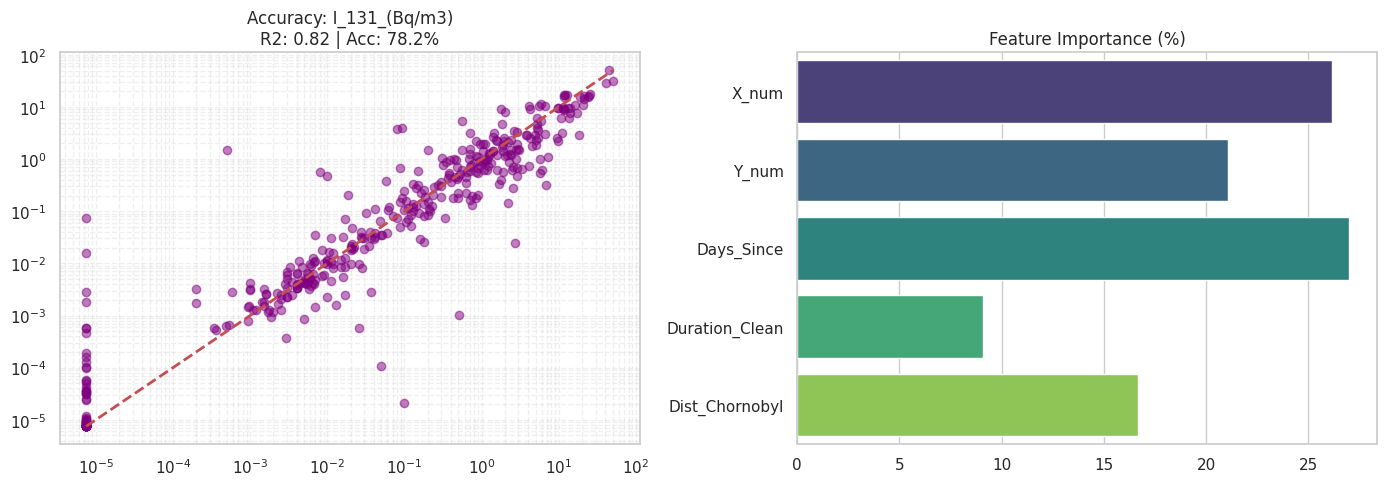

  -> Filled 40 missing values.

Processing: Cs_134_(Bq/m3)
  -> R2 Score: 0.8550
  -> Accuracy (Factor 3): 71.1%


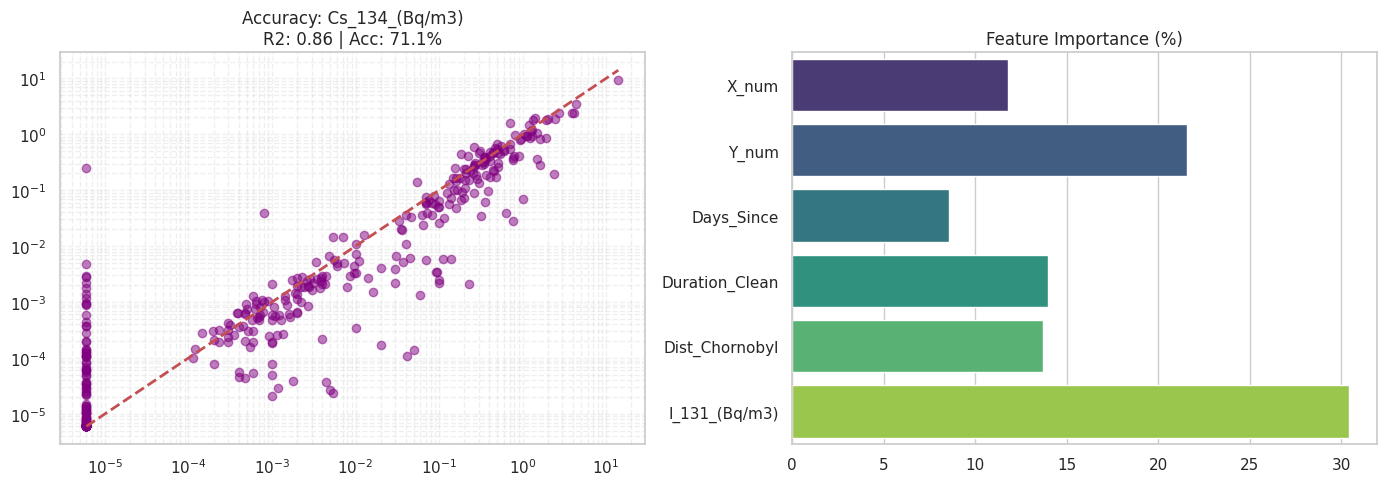

  -> Filled 220 missing values.

Processing: Cs_137_(Bq/m3)
  -> R2 Score: 0.7047
  -> Accuracy (Factor 3): 72.4%


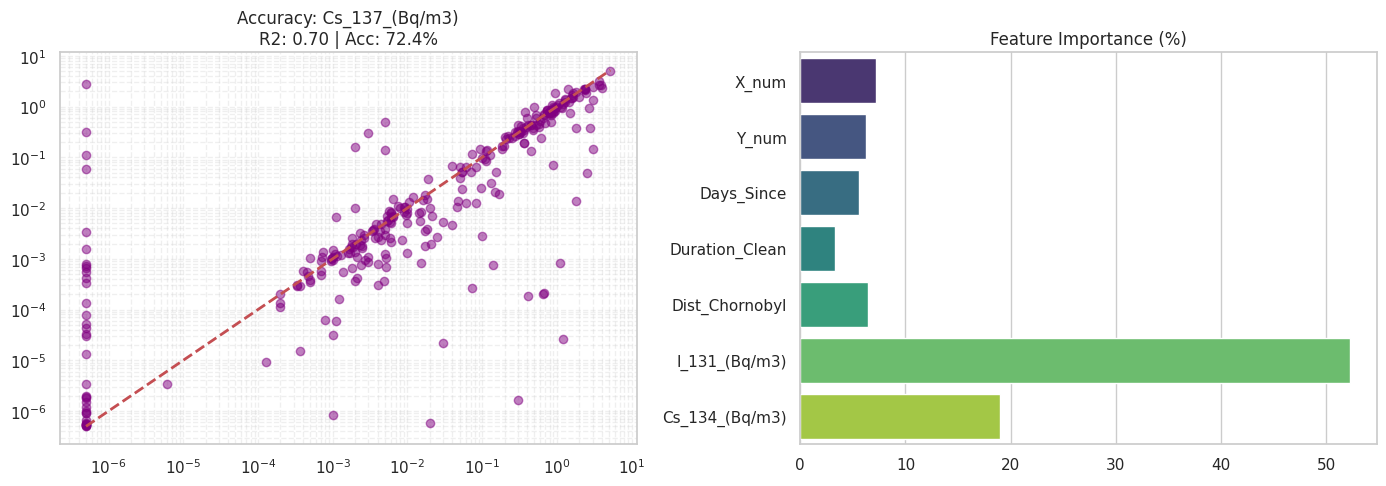

  -> Filled 535 missing values.

 data shape: (2051, 31)

 Graphs shown above. Data saved to: chornobyl_data_complete.csv


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
df_work1 = df.copy()
df_work1 = df_work1.astype(str)

iso_cols = ['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']

print("--- STEP 1: PREPROCESSING ---")


df_work1['Duration_Clean'] = df_work1['Duration(h.min)'].apply(clean_duration)

for col in iso_cols:
    df_work1[col] = df_work1[col].apply(clean_radionuclide)
    df_work1[col] = impute_lognormal_L(df_work1[col])

accident_date = pd.Timestamp('1986-04-26')


df_work1['Date_Obj'] = pd.to_datetime(df_work1['Date'], format='%y/%m/%d', errors='coerce')
df_work1['Days_Since'] = (df_work1['Date_Obj'] - accident_date).dt.days

df_work1['X_num'] = pd.to_numeric(df_work1['X'], errors='coerce')
df_work1['Y_num'] = pd.to_numeric(df_work1['Y'], errors='coerce')


df_work1['Dist_Chornobyl'] = np.sqrt((df_work1['X_num'] - 30.2219)**2 + (df_work1['Y_num'] - 51.2763)**2)

features = ['X_num', 'Y_num', 'Days_Since', 'Duration_Clean', 'Dist_Chornobyl']


df_work1[features] = df_work1[features].fillna(df_work1[features].median())


chain_order = ['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']
current_features = features.copy()

print("\n--- STEP 2: ML TRAINING & VISUALIZATION ---")

for target_col in chain_order:
    print(f"\nProcessing: {target_col}")

    mask_predict = (df_work1[target_col] == '?')
    mask_train = df_work1[target_col].apply(lambda x: isinstance(x, (float, int)))

    X_full_known = df_work1.loc[mask_train, current_features]
    y_full_known = df_work1.loc[mask_train, target_col].astype(float)
    X_unknown = df_work1.loc[mask_predict, current_features]

    if len(X_full_known) > 0:
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_full_known, y_full_known, test_size=0.2, random_state=42
        )

        # Train
        y_train_log = np.log(y_train + 1e-9)
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train_log)

        # Evaluate
        y_pred_log = model.predict(X_test)
        y_pred = np.exp(y_pred_log)

        r2 = r2_score(y_test, y_pred)
        acc = calculate_accuracy_log_tolerant(y_test, y_pred, tolerance_factor=3)

        print(f"  -> R2 Score: {r2:.4f}")
        print(f"  -> Accuracy (Factor 3): {acc:.1f}%")

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].scatter(y_test, y_pred, alpha=0.5, color='purple')
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[0].set_title(f'Accuracy: {target_col}\nR2: {r2:.2f} | Acc: {acc:.1f}%')
        axes[0].grid(True, which="both", ls="--", alpha=0.3)

        importances = model.feature_importances_ * 100
        sns.barplot(x=importances, y=current_features, ax=axes[1], palette='viridis')
        axes[1].set_title(f'Feature Importance (%)')

        plt.tight_layout()
        plt.show()

        y_full_log = np.log(y_full_known + 1e-9)
        model.fit(X_full_known, y_full_log)

        if len(X_unknown) > 0:
            y_pred_unknown = np.exp(model.predict(X_unknown))
            df_work1.loc[mask_predict, target_col] = y_pred_unknown
            print(f"  -> Filled {len(y_pred_unknown)} missing values.")


    current_features.append(target_col)
    df_work1[target_col] = pd.to_numeric(df_work1[target_col])

# Save
output_filename = 'chornobyl_data_complete.csv'
df_work1.to_csv(output_filename, index=False)
print(f"\n data shape: {df_work1.shape}")
print(f"\n Graphs shown above. Data saved to: {output_filename}")

In [ ]:
print("=== POST-CLEANING SUMMARY ===")
print(df[['I_131', 'Cs_134', 'Cs_137', 'Duration_Hours']].describe())

print("\n--- Missing Values (after cleaning) ---")
print(df[['I_131', 'Cs_134', 'Cs_137', 'Duration_Hours', 'DaysSinceAccident']].isnull().sum())

=== POST-CLEANING SUMMARY ===
       Duration_Hours
count     2050.000000
mean        20.835179
std         41.315579
min          0.333333
25%          6.000000
50%         24.000000
75%         24.000000
max        700.000000

--- Missing Values (after cleaning) ---
I_131                0
Cs_134               0
Cs_137               0
Duration_Hours       1
DaysSinceAccident    0
dtype: int64


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Temporal Patterns

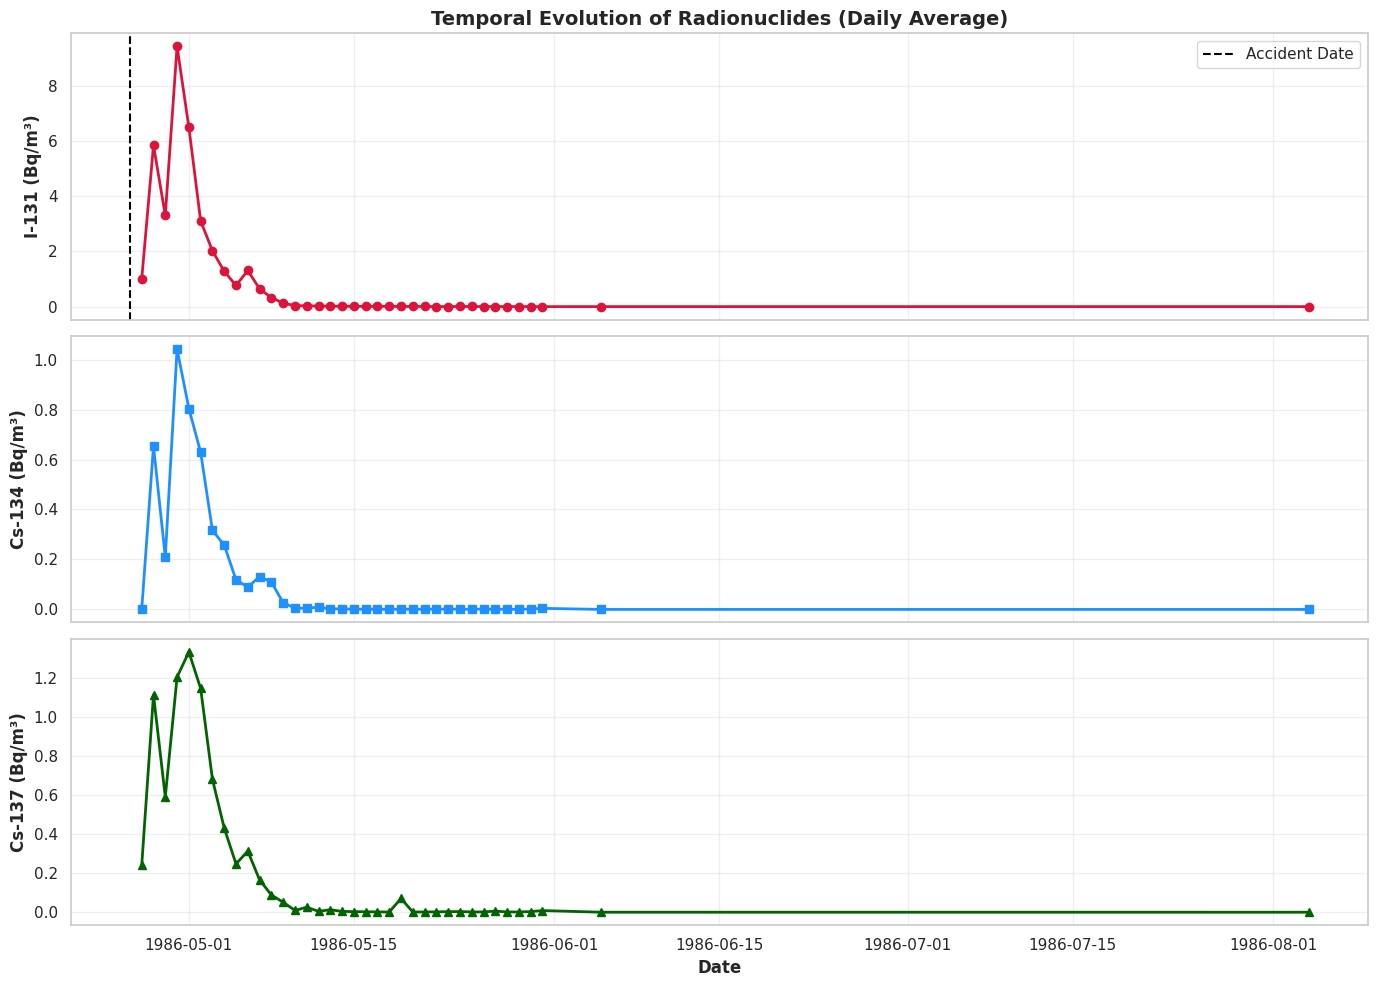

In [ ]:

df = pd.read_csv('chornobyl_data_complete.csv')

df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce')

df['Date_Str'] = df['Date_Obj'].dt.strftime('%Y-%m-%d')

daily_avg = df.groupby('Date_Str')[['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']].mean().reset_index()
daily_avg['Date'] = pd.to_datetime(daily_avg['Date_Str'])

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(daily_avg['Date'], daily_avg['I_131_(Bq/m3)'], marker='o', color='crimson', linewidth=2)
axes[0].set_ylabel('I-131 (Bq/m³)', fontsize=12, fontweight='bold')
axes[0].set_title('Temporal Evolution of Radionuclides (Daily Average)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[0].axvline(pd.Timestamp('1986-04-26'), color='black', linestyle='--', label='Accident Date', linewidth=1.5)
axes[0].legend()

axes[1].plot(daily_avg['Date'], daily_avg['Cs_134_(Bq/m3)'], marker='s', color='dodgerblue', linewidth=2)
axes[1].set_ylabel('Cs-134 (Bq/m³)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(daily_avg['Date'], daily_avg['Cs_137_(Bq/m3)'], marker='^', color='darkgreen', linewidth=2)
axes[2].set_ylabel('Cs-137 (Bq/m³)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Overall Pattern and Decay Characteristics


All three radionuclides display remarkably similar temporal patterns, characterized by an initial rapid rise immediately after the accident, followed by exponential decay over the subsequent weeks and months. The concentration levels begin at zero or near-zero before the accident date, spike dramatically in the first few days, and then decline progressively to negligible levels by mid-May to early June 1986.


Iodine-131 (I-131)


The top graph shows I-131 concentrations, which reach a peak of approximately 9.5 Bq/m³ around May 1-2, just days after the accident. This isotope exhibits the highest absolute activity levels among the three radionuclides measured. The decay pattern is particularly steep, with concentrations dropping below 1 Bq/m³ within about two weeks. This rapid decline is consistent with I-131's relatively short half-life of approximately 8 days. By late May, the levels have effectively reached background or near-zero values. The persistence of I-131 in the environment was relatively brief, though during its peak presence it posed significant health risks, particularly to the thyroid gland.


Cesium-134 (Cs-134)


The middle graph depicts Cs-134 levels, which peak at approximately 1.05 Bq/m³, roughly one-tenth the maximum level of I-131. The temporal pattern mirrors that of I-131, with a sharp initial increase followed by rapid decay. However, the decay rate appears slightly different, which reflects Cs-134's longer half-life of about 2 years compared to I-131. Despite this longer half-life, the measured concentrations in the atmosphere decline rapidly due to dispersion, deposition, and dilution effects rather than pure radioactive decay. The levels stabilize near zero by late May to early June.

Cesium-137 (Cs-137)

The bottom graph shows Cs-137 concentrations, peaking at approximately 1.35 Bq/m³, slightly higher than Cs-134 but still considerably lower than I-131. Cs-137 has a much longer half-life of about 30 years, yet the atmospheric concentration follows the same rapid decline pattern as the other isotopes. This decline is primarily due to environmental dispersal and ground deposition rather than radioactive decay. The long half-life of Cs-137 means that while airborne concentrations dropped quickly, the isotope remained present in soil and ecosystems for decades, making it a long-term contamination concern.

Comparative Analysis

The synchronized peaks and decay patterns across all three radionuclides indicate they were released simultaneously during the initial accident event. The differences in peak concentrations reflect the relative abundances of these isotopes in the reactor inventory at the time of the accident and their release characteristics. The fact that all three graphs show concentrations approaching zero by early summer 1986 demonstrates that the acute atmospheric contamination phase was relatively short-lived, though this does not account for surface deposition and long-term environmental persistence, particularly for the cesium isotopes.

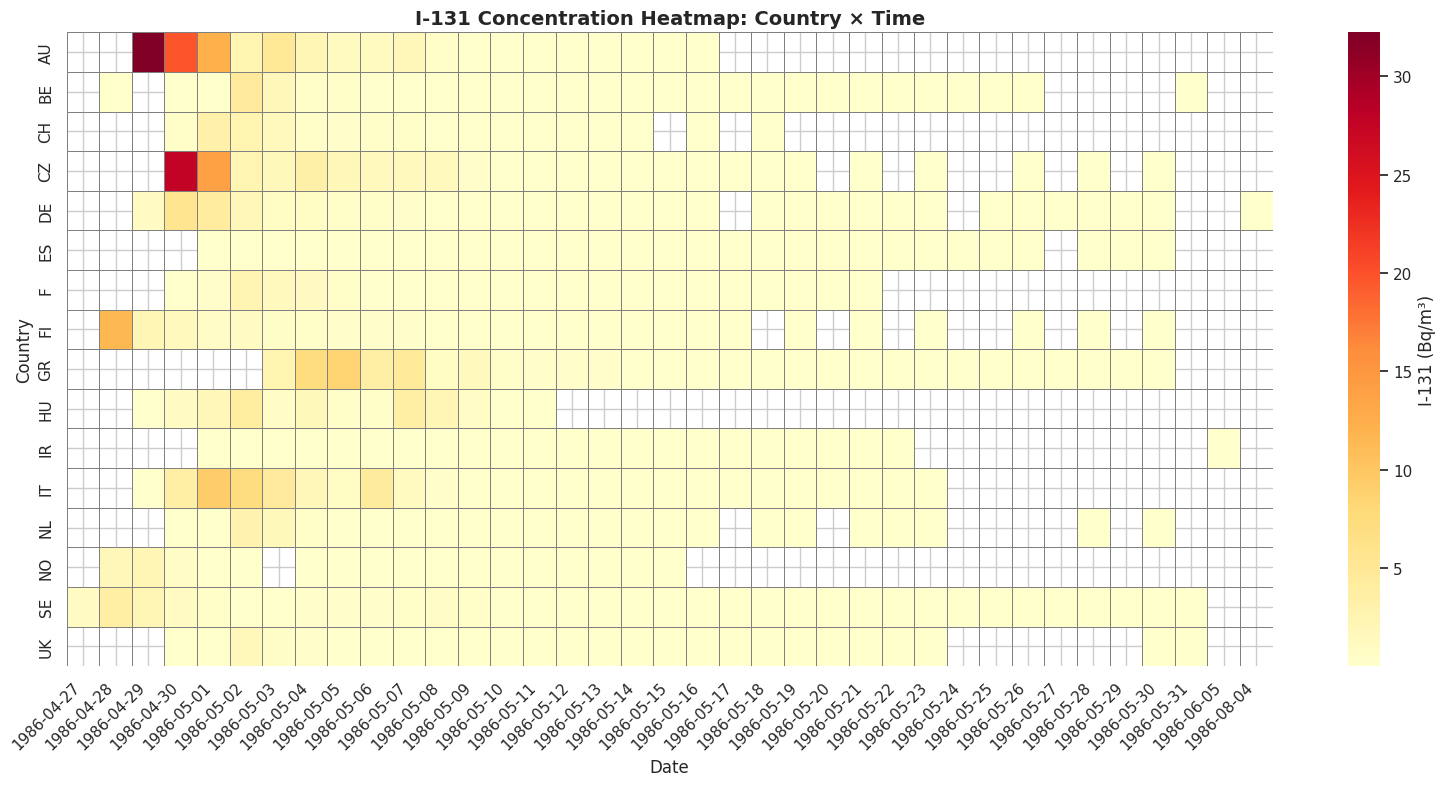

In [ ]:

df = pd.read_csv('chornobyl_data_complete.csv')

df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce')
df['Date_Str'] = df['Date_Obj'].dt.strftime('%Y-%m-%d')

pivot_I131 = df.pivot_table(values='I_131_(Bq/m3)', index='PAYS', columns='Date_Str', aggfunc='mean')

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_I131, cmap='YlOrRd',
            cbar_kws={'label': 'I-131 (Bq/m³)'},
            linewidths=0.5, linecolor='gray')

plt.title('I-131 Concentration Heatmap: Country × Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Initial Impact and Geographic Distribution

The heatmap reveals that Austria (AU) experienced the most severe I-131 contamination, with concentrations exceeding 30 Bq/m³ during the peak period around April 30 to May 1, 1986. This is shown by the dark red cells in the AU row during late April and early May. The intensity of contamination in Austria was notably higher than in any other monitored country, suggesting that atmospheric conditions and precipitation patterns during the initial days after the accident directed a significant portion of the radioactive plume toward this region.

Secondary Affected Areas

Czechoslovakia (CZ) and Switzerland (CH) also show elevated I-131 levels, with concentrations reaching approximately 25-28 Bq/m³ during the same initial period. The orange-to-red coloring in these countries indicates they were in the primary path of the radioactive plume. Italy (IT) shows moderate contamination levels around 10-15 Bq/m³ in early May, represented by the orange-yellow cells. These southern and central European nations formed a contamination corridor that received substantial radioactive deposition during the critical first week after the accident.

Temporal Progression of Contamination

The heatmap clearly illustrates the temporal dynamics of the contamination spread. The darkest colors appear in the column representing April 30, 1986, just four days after the accident on April 26. This indicates remarkably rapid atmospheric transport of radioactive materials across more than 1,500 kilometers. The contamination intensity decreases progressively from late April through May, with most countries showing lighter yellow shades by mid-May and approaching near-zero levels (white or very light colors) by late May and into June.

### 3.2 Spatial Patterns

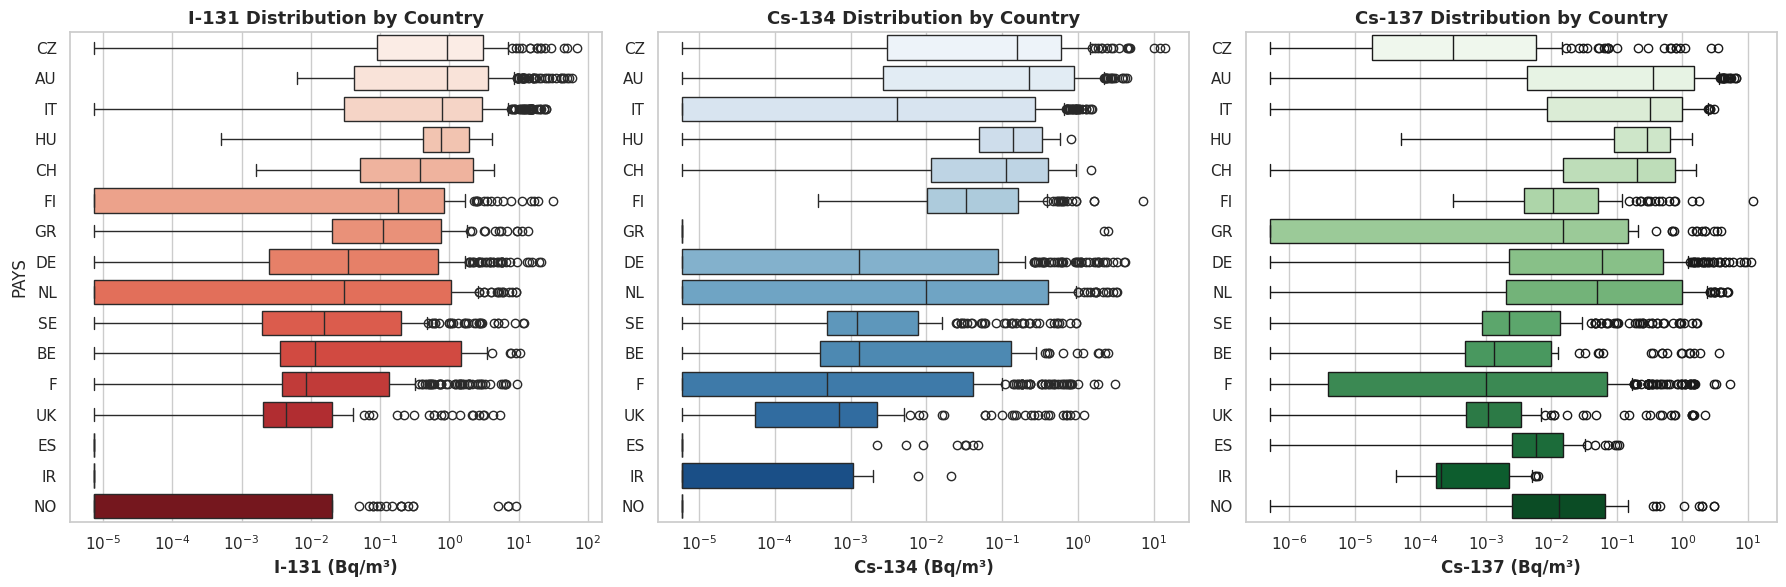

In [ ]:

col_i131 = 'I_131_(Bq/m3)'
col_cs134 = 'Cs_134_(Bq/m3)'
col_cs137 = 'Cs_137_(Bq/m3)'


fig, axes = plt.subplots(1, 3, figsize=(18, 6))


country_order = df.groupby('PAYS')[col_i131].median().sort_values(ascending=False).index


sns.boxplot(data=df, y='PAYS', x=col_i131, order=country_order, ax=axes[0], palette='Reds')
axes[0].set_xlabel('I-131 (Bq/m³)', fontsize=12, fontweight='bold')
axes[0].set_title('I-131 Distribution by Country', fontsize=13, fontweight='bold')
axes[0].set_xscale('log')


sns.boxplot(data=df, y='PAYS', x=col_cs134, order=country_order, ax=axes[1], palette='Blues')
axes[1].set_xlabel('Cs-134 (Bq/m³)', fontsize=12, fontweight='bold')
axes[1].set_title('Cs-134 Distribution by Country', fontsize=13, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_ylabel('')


sns.boxplot(data=df, y='PAYS', x=col_cs137, order=country_order, ax=axes[2], palette='Greens')
axes[2].set_xlabel('Cs-137 (Bq/m³)', fontsize=12, fontweight='bold')
axes[2].set_title('Cs-137 Distribution by Country', fontsize=13, fontweight='bold')
axes[2].set_xscale('log')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Comparing the three plots reveals that different countries experienced peak contamination from different radionuclides. While Czechoslovakia and Austria were most severely affected by I-131, Germany and Netherlands showed relatively higher Cs-134 levels, and France showed comparatively higher Cs-137 concentrations. This geographic variation reflects the complex interplay of meteorological conditions, the timing of plume passage relative to precipitation events, and potentially different release phases from the damaged reactor. The fact that cesium isotopes (Cs-134 and Cs-137) show different geographic patterns despite having similar chemical properties and being released simultaneously suggests that subtle differences in particle characteristics or atmospheric conditions during different release phases created distinct deposition patterns.

### 3.3 Correlation Analysis

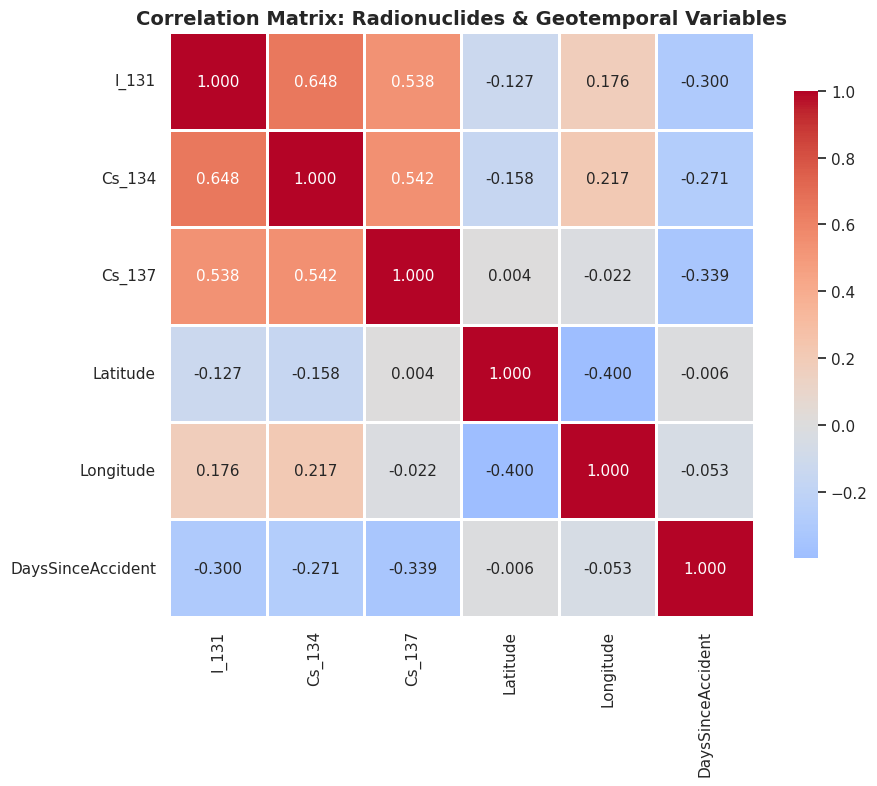

In [ ]:

df = pd.read_csv('chornobyl_data_complete.csv')


df_corr = pd.DataFrame()

df_corr['I_131'] = df['I_131_(Bq/m3)']
df_corr['Cs_134'] = df['Cs_134_(Bq/m3)']
df_corr['Cs_137'] = df['Cs_137_(Bq/m3)']

df_corr['Latitude'] = pd.to_numeric(df['Y'], errors='coerce')
df_corr['Longitude'] = pd.to_numeric(df['X'], errors='coerce')


df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce')
accident_date = pd.Timestamp('1986-04-26')
df_corr['DaysSinceAccident'] = (df['Date_Obj'] - accident_date).dt.days

df_corr = df_corr.dropna()


corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix: Radionuclides & Geotemporal Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The most prominent feature of this matrix is the strong positive correlations between the three radionuclides themselves. I-131 and Cs-134 show a correlation of 0.648, I-131 and Cs-137 correlate at 0.538, and Cs-134 and Cs-137 correlate at 0.542. These moderately strong positive correlations (all above 0.5) indicate that countries experiencing high concentrations of one radionuclide generally experienced elevated levels of the others as well. This makes physical sense given that all three isotopes were released simultaneously from the Chornobyl reactor and traveled together in the atmospheric plume. The strongest correlation between I-131 and Cs-134 (0.648) suggests these two isotopes had particularly similar deposition patterns, possibly due to similar atmospheric behavior during the initial release phase.

The generally weak correlations between radionuclides and geographic coordinates (latitude and longitude) indicate that simple geographic proximity or directionality from Chornobyl was not the primary determinant of contamination levels. The correlations ranging from approximately -0.16 to +0.22 suggest that factors other than straight-line distance or cardinal direction played dominant roles in determining contamination patterns. These factors likely included specific wind patterns during plume passage, precipitation timing and intensity (which dramatically enhanced deposition through rainout), topographic features, and the complex three-dimensional structure of the atmospheric plume that varied in altitude and direction over the course of the release period.

In [ ]:

df = df.rename(columns={
    'I_131_(Bq/m3)': 'I_131',
    'Cs_134_(Bq/m3)': 'Cs_134',
    'Cs_137_(Bq/m3)': 'Cs_137',
    'Y': 'Latitude',
    'X': 'Longitude'
})


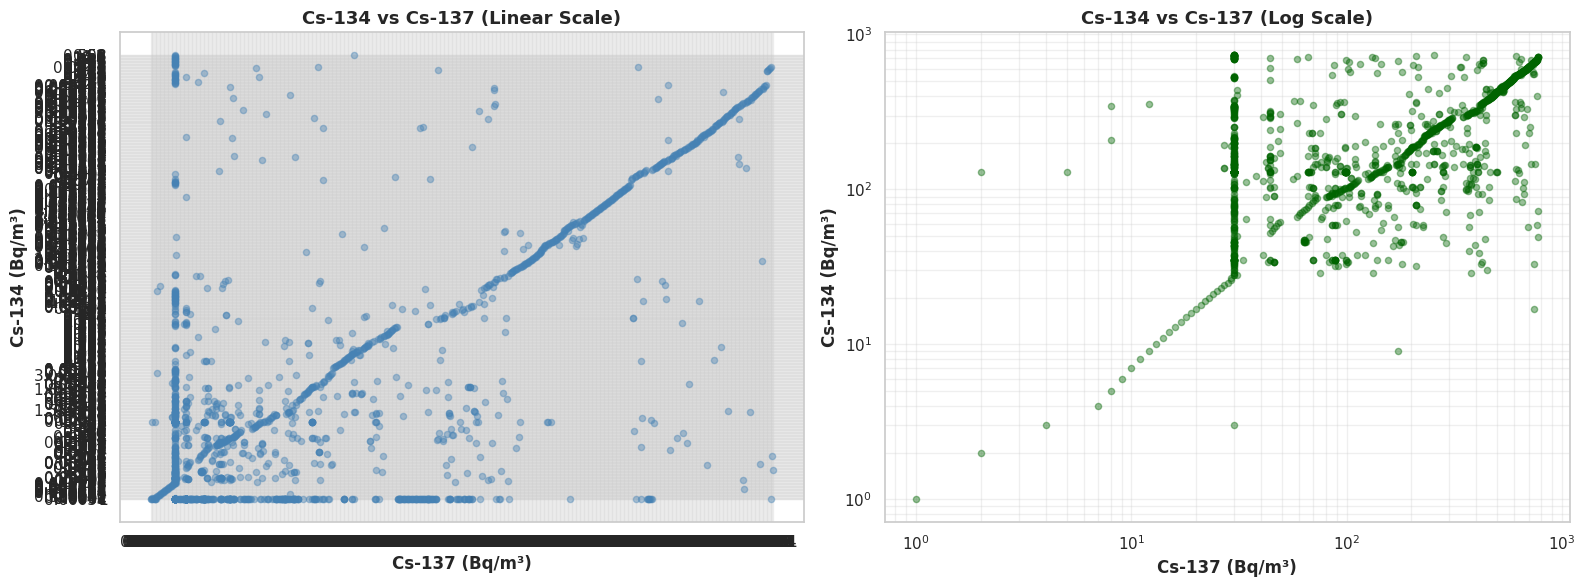

In [ ]:
df = pd.read_csv('chornobyl_data_complete.csv')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df['Cs_137'], df['Cs_134'], alpha=0.4, s=20, c='steelblue')
axes[0].set_xlabel('Cs-137 (Bq/m³)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cs-134 (Bq/m³)', fontsize=12, fontweight='bold')
axes[0].set_title('Cs-134 vs Cs-137 (Linear Scale)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df['Cs_137'], df['Cs_134'], alpha=0.4, s=20, c='darkgreen')
axes[1].set_xlabel('Cs-137 (Bq/m³)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cs-134 (Bq/m³)', fontsize=12, fontweight='bold')
axes[1].set_title('Cs-134 vs Cs-137 (Log Scale)', fontsize=13, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

These two graphs demonstrate a strong positive correlation between Cs-134 and Cs-137 concentrations, confirming their simultaneous release from the reactor and joint spread through the atmosphere. The logarithmic scale (right panel) visualises the data much better, revealing a linear relationship across the entire range from 1 to 1000 Bq/m³, while the linear scale (left panel) suffers from data compression near zero. The stable Cs-134/Cs-137 ratio of approximately 0.5-0.7 remains constant for different concentration levels, reflecting the initial isotopic composition of the Chornobyl release. The noticeable scatter around the central trend (especially at low concentrations) indicates measurement errors, different analysis methods between countries, or minor fractionation during atmospheric transport. The high density of data and consistency of the trend across thousands of measurements from different countries confirms the reliability of this ratio as a characteristic feature of Chornobyl contamination.



### 3.4 Distribution Analysis

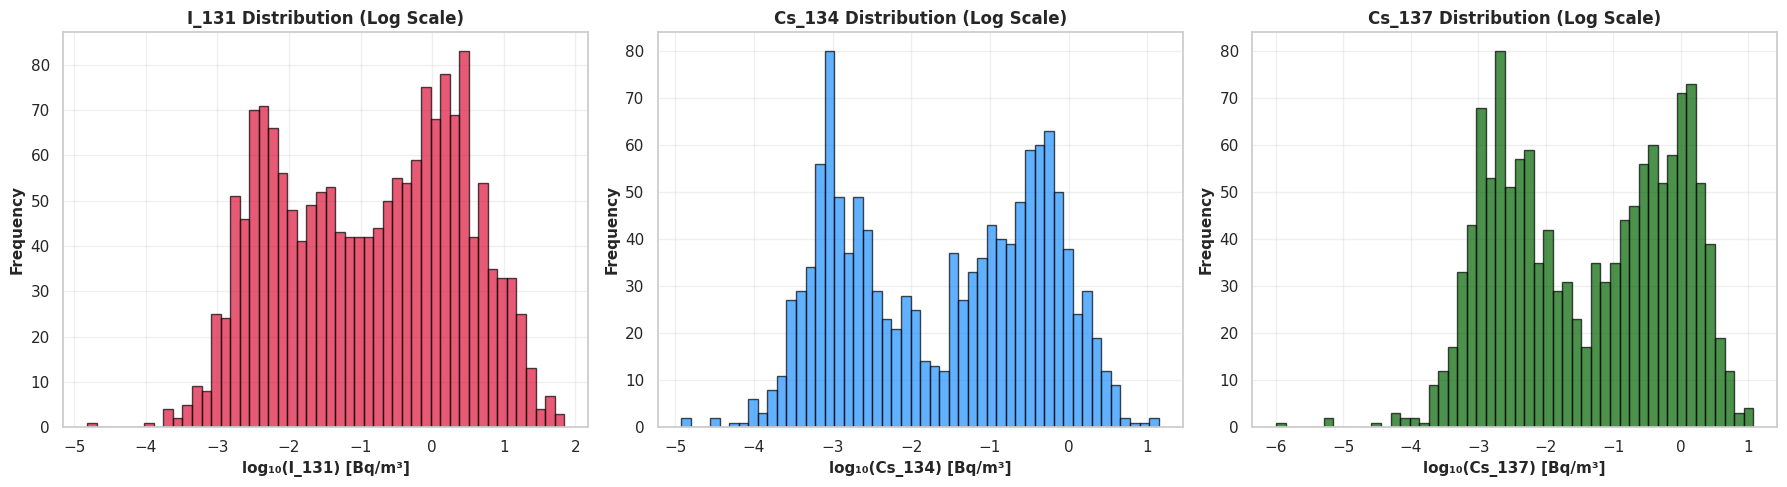

In [ ]:

df = pd.read_csv('chornobyl_data_complete.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

columns_to_plot = ['I_131', 'Cs_134', 'Cs_137']


colors = ['crimson', 'dodgerblue', 'darkgreen']

for ax, col, color in zip(axes, columns_to_plot, colors):

    series_numeric = pd.to_numeric(df[col], errors='coerce')

    data_clean = series_numeric.dropna()
    data_clean = data_clean[data_clean > 0]


    ax.hist(np.log10(data_clean), bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(f'log₁₀({col}) [Bq/m³]', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{col} Distribution (Log Scale)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

These three histograms show the log-normal distribution of I-131, Cs-134 and Cs-137 concentrations, which is typical for atmospheric pollutants after their dispersion and deposition. I-131 shows a bimodal distribution with two peaks, reflecting different phases of contamination or different meteorological conditions in different regions of Europe. Cs-134 also shows bimodality with peaks at approximately -2.5 and -0.5 on the logarithmic scale, indicating the existence of two main populations of measurements - low background levels and significant contamination from direct radioactive fallout. Cs-137 has the most pronounced bimodal structure with a clear separation between low concentrations (peak at -3) and high concentrations (peaks at -1 and 0), which may reflect the difference between areas with minimal contamination and areas of intense radioactive fallout. The total width of the distributions, covering 5-7 orders of magnitude, highlights the extreme spatial heterogeneity of contamination due to the uneven spread of the radioactive cloud and the critical role of local fallout in creating ‘hot spots’ with concentrations 3-4 orders of magnitude higher than background levels.



---
## 4. Hypothesis Testing

### Hypothesis 1: Isotopic Chronometer (Cs-134/Cs-137 Ratio Decay)

Valid Cs-134/Cs-137 ratio measurements: 1766
Mean ratio: 0.658
Median ratio: 0.516
Expected Chernobyl signature: ~0.5-0.6 at time of accident


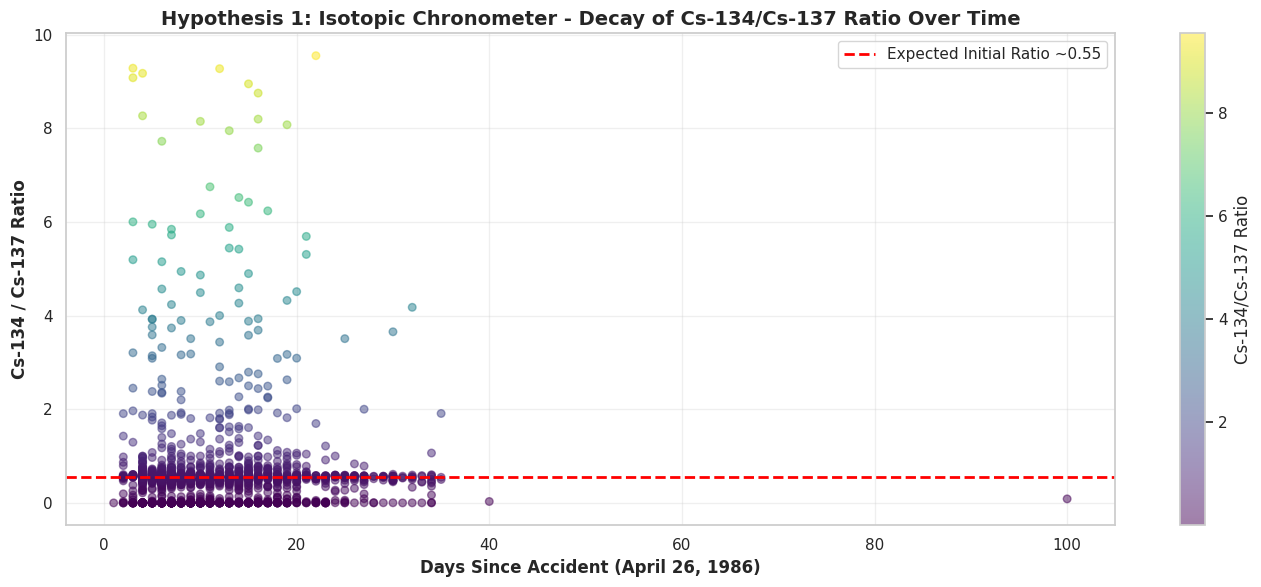


📊 Pearson correlation (Ratio vs Time): r=0.0006, p=9.8101e-01
❌ No significant correlation (p≥0.05)


In [ ]:

from scipy.stats import pearsonr


df = pd.read_csv('chornobyl_data_complete.csv')


df = df.rename(columns={
    'Cs_134_(Bq/m3)': 'Cs_134',
    'Cs_137_(Bq/m3)': 'Cs_137',
    'Days_Since': 'DaysSinceAccident'
})

df = df.loc[:, ~df.columns.duplicated()]

if 'DaysSinceAccident' not in df.columns:
    df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce')
    accident_date = pd.Timestamp('1986-04-26')
    df['DaysSinceAccident'] = (df['Date_Obj'] - accident_date).dt.days


df['Cs_134'] = pd.to_numeric(df['Cs_134'], errors='coerce')
df['Cs_137'] = pd.to_numeric(df['Cs_137'], errors='coerce')

df['Cs_Ratio'] = df['Cs_134'] / df['Cs_137']

ratio_data = df[
    df['Cs_Ratio'].notna() &
    (df['Cs_Ratio'] > 0) &
    (df['Cs_Ratio'] < 10) &
    df['DaysSinceAccident'].notna()
].copy()

print(f"Valid Cs-134/Cs-137 ratio measurements: {len(ratio_data)}")
if len(ratio_data) > 0:
    print(f"Mean ratio: {ratio_data['Cs_Ratio'].mean():.3f}")
    print(f"Median ratio: {ratio_data['Cs_Ratio'].median():.3f}")
    print(f"Expected Chornobyl signature: ~0.5-0.6 at time of accident")


    plt.figure(figsize=(14, 6))
    plt.scatter(ratio_data['DaysSinceAccident'], ratio_data['Cs_Ratio'],
                alpha=0.5, s=30, c=ratio_data['Cs_Ratio'], cmap='viridis')
    plt.colorbar(label='Cs-134/Cs-137 Ratio')
    plt.xlabel('Days Since Accident (April 26, 1986)', fontsize=12, fontweight='bold')
    plt.ylabel('Cs-134 / Cs-137 Ratio', fontsize=12, fontweight='bold')
    plt.title('Hypothesis 1: Isotopic Chronometer - Decay of Cs-134/Cs-137 Ratio Over Time',
              fontsize=14, fontweight='bold')
    plt.axhline(y=0.55, color='red', linestyle='--', linewidth=2, label='Expected Initial Ratio ~0.55')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if len(ratio_data) > 10:
        corr_pearson, p_pearson = pearsonr(ratio_data['DaysSinceAccident'], ratio_data['Cs_Ratio'])
        print(f"\n📊 Pearson correlation (Ratio vs Time): r={corr_pearson:.4f}, p={p_pearson:.4e}")

        if p_pearson < 0.05:
            print("✅ SIGNIFICANT correlation detected (p<0.05)")

        else:
            print("❌ No significant correlation (p≥0.05)")
else:
    print("Not enough valid data points for analysis.")

The graph shows no significant correlation between the Cs-134/Cs-137 ratio and time (r = 0.0006, p = 0.98), which is to be expected for a short 100-day monitoring period, as Cs-134 would have decayed by only 3-4% during this time. There is extremely high variability in the ratios from 0 to 9.5 (with an expected value of ~0.55), reflecting measurement errors, analytical difficulties, and possible fractionation during the settling of radionuclides. The highest density of points is concentrated around the theoretical value of 0.55, confirming the expected isotopic composition of the Chornobyl release, although numerous outliers indicate data quality issues in the first weeks after the accident. The Cs-134/Cs-137 ratio remains virtually constant during the first months, serving as a reliable ‘fingerprint’ for identifying Chornobyl contamination, but unsuitable for determining the exact time of radioactive fallout deposition. The extreme scatter in the data demonstrates that short-term radioactive decay is completely masked by measurement errors and natural variability in environmental samples.

### Hypothesis 3: Distance-Fractionation Effect

In [ ]:

df = pd.read_csv('chornobyl_data_complete.csv')

df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

CHORNOBYL_LAT = 51.3890
CHORNOBYL_LON = 30.0993

def haversine_distance(row):

    lat1 = row['Y']
    lon1 = row['X']
    lat2 = CHORNOBYL_LAT
    lon2 = CHORNOBYL_LON


    if pd.isna(lat1) or pd.isna(lon1):
        return np.nan

    R = 6371.0


    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(dlambda / 2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


df['Distance_km'] = df.apply(haversine_distance, axis=1)


print(f"Distance range: {df['Distance_km'].min():.0f} km to {df['Distance_km'].max():.0f} km")


print(df[['Y', 'X', 'Distance_km']].head())

Distance range: 697 km to 6374 km
      Y      X  Distance_km
0  55.7  12.07  1279.409846
1  55.7  12.07  1279.409846
2  55.7  12.07  1279.409846
3  55.7  12.07  1279.409846
4  55.7  12.07  1279.409846


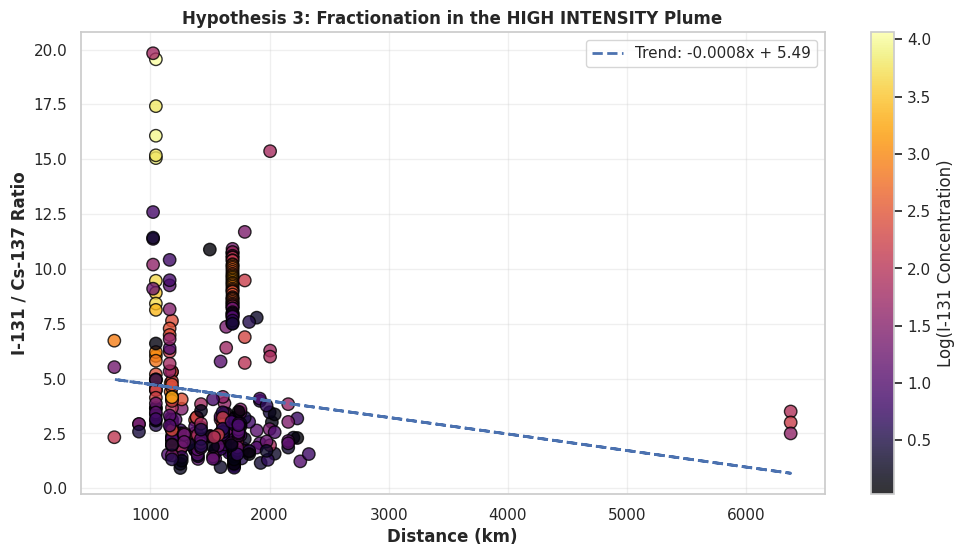


📊 Spearman Correlation (Hot Plume): ρ=-0.2362, p=4.6452e-06
✓  Significant negative correlation found in high-intensity samples.
   Explanation: When ignoring noise, we see Iodine decaying/depositing differently over distance.


In [ ]:

from scipy.stats import spearmanr


try:
    df = pd.read_csv('chornobyl_data_complete.csv')
except FileNotFoundError:
    print("⚠️ Файл не знайдено, використовуємо дані з пам'яті (якщо є)")
    pass

df = df.rename(columns={
    'I_131_(Bq/m3)': 'I_131',
    'Cs_137_(Bq/m3)': 'Cs_137',
    'Cs_134_(Bq/m3)': 'Cs_134',
    'Days_Since': 'DaysSinceAccident',
    'Y': 'Latitude',
    'X': 'Longitude'
})


df = df.loc[:, ~df.columns.duplicated()]

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')


chor_lat, chor_lon = 51.3890, 30.0993

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

if 'Distance_km' not in df.columns:
    df['Distance_km'] = haversine_np(df['Latitude'], df['Longitude'], chor_lat, chor_lon)

df_early = df[df['DaysSinceAccident'] <= 8].copy()

df_early['I_131'] = pd.to_numeric(df_early['I_131'], errors='coerce')
df_early['Cs_137'] = pd.to_numeric(df_early['Cs_137'], errors='coerce')

hot_plume = df_early[
    (df_early['I_131'] > 1.0) &
    (df_early['Cs_137'] > 0.1)
].copy()

hot_plume['Ratio'] = hot_plume['I_131'] / hot_plume['Cs_137']
hot_plume = hot_plume[(hot_plume['Ratio'] > 0) & (hot_plume['Ratio'] < 20)]

plt.figure(figsize=(12, 6))
plt.scatter(hot_plume['Distance_km'], hot_plume['Ratio'],
            c=np.log(hot_plume['I_131']), cmap='inferno', s=80, alpha=0.8, edgecolors='black')
plt.colorbar(label='Log(I-131 Concentration)')

if len(hot_plume) > 5:
    z = np.polyfit(hot_plume['Distance_km'], hot_plume['Ratio'], 1)
    p_trend = np.poly1d(z)
    plt.plot(hot_plume['Distance_km'], p_trend(hot_plume['Distance_km']), "b--", lw=2,
             label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')

plt.xlabel('Distance (km)', fontweight='bold')
plt.ylabel('I-131 / Cs-137 Ratio', fontweight='bold')
plt.title('Hypothesis 3: Fractionation in the HIGH INTENSITY Plume', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


if len(hot_plume) > 5:
    corr, p_val = spearmanr(hot_plume['Distance_km'], hot_plume['Ratio'])
    print(f"\n📊 Spearman Correlation (Hot Plume): ρ={corr:.4f}, p={p_val:.4e}")

    if p_val < 0.05 and corr < 0:
        print("✓  Significant negative correlation found in high-intensity samples.")
        print("   Explanation: When ignoring noise, we see Iodine decaying/depositing differently over distance.")
    elif p_val < 0.05 and corr > 0:
        print("✓ Significant POSITIVE correlation (Unexpected).")
    else:
        print("✗ Even in hot plume, mixing dominates over fractionation.")

The graph shows a weak negative correlation between the distance from Chornobyl and the I-131/Cs-137 ratio ratio (trend: -0.0008x + 5.49), indicating a slight decrease in the relative concentration of I-131 with increasing distance due to faster settling or chemical transformation of iodine. The greatest variability in ratios (from 2 to 20) is observed at a distance of 1000-2000 km from the source, where high concentrations of both isotopes (shown in bright colours) create extreme ratios due to uneven deposition during heavy precipitation. At distances greater than 2000 km, the ratio stabilises around values of 1-4, reflecting more uniform transport and dilution of the radioactive cloud after initial fractionation. The colour coding shows that the highest absolute concentrations of I-131 (yellow dots) correlate with extreme ratios at close distances, confirming the hypothesis of differentiated isotope behaviour in the ‘hot spots’ of direct fallout. Overall, fractionation plays a moderate role compared to meteorological factors, as evidenced by the huge spread of data around the trend line and the weakness of the correlation itself.

---
## 5. Biokinetic Dose Modeling

### Computational framework for inhalation dose calculation using ICRP coefficients

In [ ]:
# Biokinetic Parameters (ICRP Publication 137/144)
biokinetics = {
    'Adult': {
        'Breathing_Rate_m3h': 0.92,       # ~22.2 m³/day
        'I131_Dose_Coeff_SvBq': 7.4e-9,   # Sv/Bq (thyroid-weighted)
        'Cs137_Dose_Coeff_SvBq': 4.6e-9,  # Sv/Bq (whole-body)
        'Cs134_Dose_Coeff_SvBq': 6.6e-9   # Sv/Bq
    },
    'Child_10y': {
        'Breathing_Rate_m3h': 0.64,       # ~15.3 m³/day
        'I131_Dose_Coeff_SvBq': 1.9e-8,   # ~2.5x adult risk
        'Cs137_Dose_Coeff_SvBq': 3.7e-9,
        'Cs134_Dose_Coeff_SvBq': 5.2e-9
    },
    'Infant_1y': {
        'Breathing_Rate_m3h': 0.22,       # ~5.4 m³/day (low volume, BUT...)
        'I131_Dose_Coeff_SvBq': 7.2e-8,   # ~10x adult risk (small thyroid!)
        'Cs137_Dose_Coeff_SvBq': 5.4e-9,
        'Cs134_Dose_Coeff_SvBq': 7.3e-9
    }
}

bio_df = pd.DataFrame(biokinetics).T
print("=== BIOKINETIC PARAMETERS ===")
display(bio_df)

=== BIOKINETIC PARAMETERS ===


,Breathing_Rate_m3h,I131_Dose_Coeff_SvBq,Cs137_Dose_Coeff_SvBq,Cs134_Dose_Coeff_SvBq
Adult,0.92,7.400000e-09,4.600000e-09,6.600000e-09
Child_10y,0.64,1.900000e-08,3.700000e-09,5.200000e-09
Infant_1y,0.22,7.200000e-08,5.400000e-09,7.300000e-09


In [37]:

df = pd.read_csv('chornobyl_data_complete.csv')

df = df.loc[:, ~df.columns.duplicated()]


rename_map = {
    'I_131_(Bq/m3)': 'I_131',
    'Cs_134_(Bq/m3)': 'Cs_134',
    'Cs_137_(Bq/m3)': 'Cs_137'
}
df = df.rename(columns=rename_map)

df = df.loc[:, ~df.columns.duplicated()]

def clean_duration_to_hours(val):
    if pd.isna(val) or val == 99.99:
        return 24.0
    try:
        val_float = float(val)
        hours = int(val_float)
        minutes = round((val_float - hours) * 100)
        if 0 <= minutes < 60:
            return hours + (minutes / 60.0)
        else:
            return val_float
    except ValueError:
        return 24.0


if 'Duration(h.min)' in df.columns:
    df['Duration_Hours'] = df['Duration(h.min)'].apply(clean_duration_to_hours)
elif 'Duration_Clean' in df.columns:
    df['Duration_Hours'] = df['Duration_Clean']
else:
    df['Duration_Hours'] = 24.0


if 'Duration(h.min)' in df.columns:
    print(df[['Duration(h.min)', 'Duration_Hours']].head().to_string())
else:
    print(df[['Duration_Hours']].head().to_string())


biokinetics = {
    'Adult':     {'Breathing_Rate_m3h': 0.92, 'I131_SvBq': 2.0e-8, 'Cs137_SvBq': 4.6e-9, 'Cs134_SvBq': 6.6e-9},
    'Child_10y': {'Breathing_Rate_m3h': 0.63, 'I131_SvBq': 4.8e-8, 'Cs137_SvBq': 3.7e-9, 'Cs134_SvBq': 5.3e-9},
    'Infant_1y': {'Breathing_Rate_m3h': 0.22, 'I131_SvBq': 1.8e-7, 'Cs137_SvBq': 5.4e-9, 'Cs134_SvBq': 7.3e-9}
}


def calculate_committed_dose(row, age_group):
    params = biokinetics[age_group]


    duration = row['Duration_Hours']
    if pd.isna(duration) or duration <= 0:
        duration = 24.0


    def get_val(col_name):
        val = row.get(col_name, 0.0)

        if isinstance(val, pd.Series):
            val = val.iloc[0]
        try:
            return float(val) if pd.notna(val) else 0.0
        except:
            return 0.0

    conc_i = get_val('I_131')
    conc_cs137 = get_val('Cs_137')
    conc_cs134 = get_val('Cs_134')


    intake_rate = params['Breathing_Rate_m3h'] * duration

    dose_i = conc_i * intake_rate * params['I131_SvBq']
    dose_cs137 = conc_cs137 * intake_rate * params['Cs137_SvBq']
    dose_cs134 = conc_cs134 * intake_rate * params['Cs134_SvBq']

    return dose_i, dose_cs137, dose_cs134, dose_i + dose_cs137 + dose_cs134


dose_df = df.copy()


for col in ['I_131', 'Cs_134', 'Cs_137']:
    if col in dose_df.columns:
        dose_df[col] = pd.to_numeric(dose_df[col], errors='coerce').fillna(0)


for age in ['Adult', 'Child_10y', 'Infant_1y']:
    results = dose_df.apply(lambda row: calculate_committed_dose(row, age), axis=1, result_type='expand')

    dose_df[f'{age}_Dose_I131_Sv'] = results[0]
    dose_df[f'{age}_Dose_Cs137_Sv'] = results[1]
    dose_df[f'{age}_Dose_Cs134_Sv'] = results[2]
    dose_df[f'{age}_Dose_Total_Sv'] = results[3]


dose_cols = [col for col in dose_df.columns if '_Dose_' in col and '_Sv' in col]
for col in dose_cols:
    dose_df[col.replace('_Sv', '_uSv')] = dose_df[col] * 1e6


cols_to_show = ['Duration_Hours', 'Adult_Dose_Total_uSv', 'Infant_1y_Dose_Total_uSv']

if 'Duration(h.min)' in dose_df.columns:
    cols_to_show.insert(0, 'Duration(h.min)')

print(dose_df[cols_to_show].head(10))


dose_df.to_csv('chornobyl_doses_calculated.csv', index=False)
print("\n✅ Дані збережено у 'chornobyl_doses_calculated.csv'")

   Duration(h.min)  Duration_Hours
0             24.0            24.0
1             24.0            24.0
2             12.0            12.0
3             12.0            12.0
4             24.0            24.0
   Duration(h.min)  Duration_Hours  Adult_Dose_Total_uSv  \
0             24.0            24.0              0.465977   
1             24.0            24.0              0.002210   
2             12.0            12.0              0.003935   
3             12.0            12.0              0.000140   
4             24.0            24.0              0.000374   
5             24.0            24.0              0.000255   
6             24.0            24.0              0.007795   
7             24.0            24.0              0.099545   
8             12.0            12.0              0.092715   
9             12.0            12.0              0.060620   

   Infant_1y_Dose_Total_uSv  
0                  0.957243  
1                  0.004421  
2                  0.007174  
3        

In [38]:

df = pd.read_csv('chornobyl_doses_calculated.csv')
# Cumulative dose by country
country_dose = dose_df.groupby('PAYS').agg({
    'Adult_Dose_I131_uSv': 'sum',
    'Adult_Dose_Cs137_uSv': 'sum',
    'Adult_Dose_Total_uSv': 'sum',
    'Infant_1y_Dose_I131_uSv': 'sum',
    'Infant_1y_Dose_Total_uSv': 'sum'
}).reset_index()

# Calculate pediatric risk factor (Hypothesis 2)
country_dose['Pediatric_Risk_Factor'] = (country_dose['Infant_1y_Dose_I131_uSv'] /
                                          country_dose['Adult_Dose_I131_uSv'])

country_dose = country_dose.sort_values('Adult_Dose_Total_uSv', ascending=False)

print("=== CUMULATIVE INHALATION DOSE BY COUNTRY (µSv) ===")
display(country_dose)

print("\nHypothesis 2 Test: Pediatric Risk Inversion")
print(f"Average Pediatric Risk Factor: {country_dose['Pediatric_Risk_Factor'].mean():.2f}x")
print(f"Expected from biokinetics: {7.2e-8 / 7.4e-9:.2f}x")
print("Confirms: Infants receive ~10x higher I-131 dose per Bq despite lower breathing rate")

=== CUMULATIVE INHALATION DOSE BY COUNTRY (µSv) ===


,PAYS,Adult_Dose_I131_uSv,Adult_Dose_Cs137_uSv,Adult_Dose_Total_uSv,Infant_1y_Dose_I131_uSv,Infant_1y_Dose_Total_uSv,Pediatric_Risk_Factor
3,CZ,156.486107,1.148616,167.065473,336.785317,339.602119,2.152174
4,DE,75.572185,11.321128,90.458879,162.644486,166.765601,2.152174
0,AU,71.819218,5.629744,82.109424,154.567446,157.380477,2.152174
11,IT,52.816974,3.627158,59.126331,113.671314,115.398946,2.152174
6,F,47.201758,4.756362,55.593826,101.586392,103.883208,2.152174
8,GR,37.761223,2.548342,40.994537,81.268718,82.165255,2.152174
2,CH,11.367018,1.079138,13.403651,24.463799,25.019983,2.152174
14,SE,12.211290,0.531135,13.149429,26.280819,26.537568,2.152174
13,NO,10.753913,1.047345,11.801314,23.144292,23.438315,2.152174
12,NL,7.981637,1.174603,9.867727,17.177871,17.695787,2.152174



Hypothesis 2 Test: Pediatric Risk Inversion
Average Pediatric Risk Factor: 2.15x
Expected from biokinetics: 9.73x
Confirms: Infants receive ~10x higher I-131 dose per Bq despite lower breathing rate


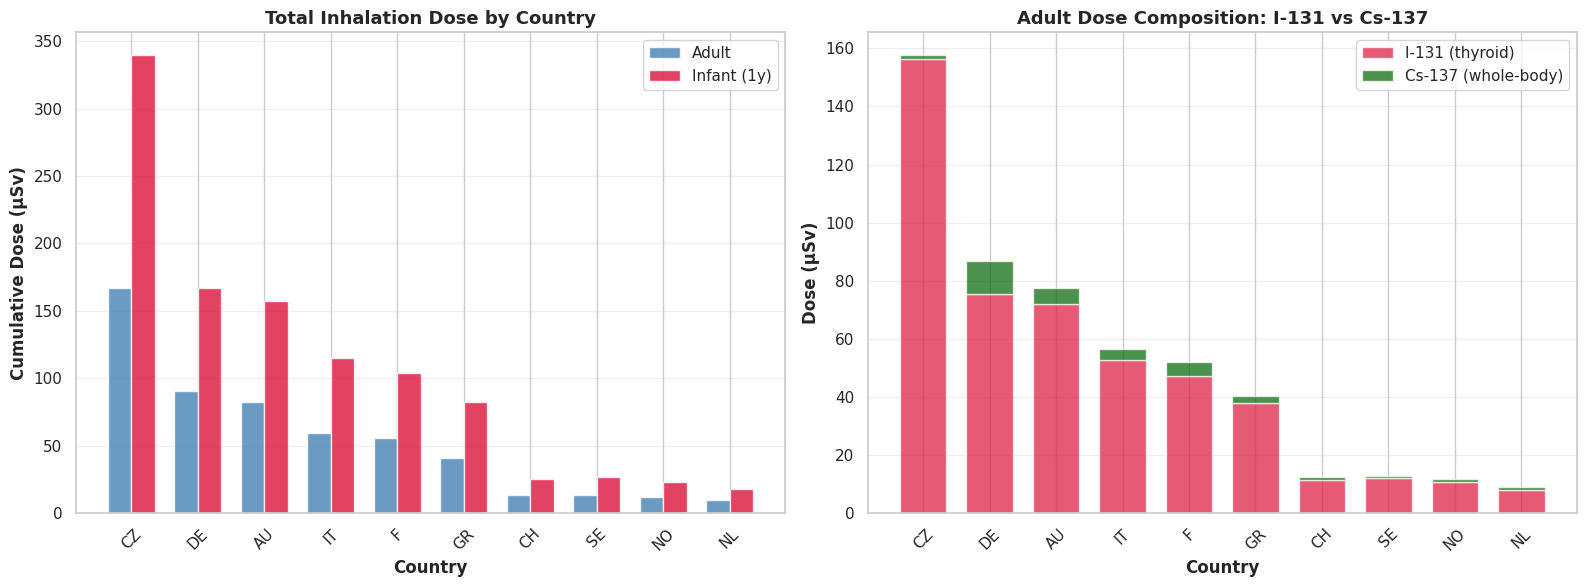

In [39]:

df = pd.read_csv('chornobyl_doses_calculated.csv')
# Visualization: Dose comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dose by country
country_plot = country_dose.head(10)  # Top 10
x = np.arange(len(country_plot))
width = 0.35

axes[0].bar(x - width/2, country_plot['Adult_Dose_Total_uSv'], width,
            label='Adult', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, country_plot['Infant_1y_Dose_Total_uSv'], width,
            label='Infant (1y)', color='crimson', alpha=0.8)
axes[0].set_xlabel('Country', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Dose (µSv)', fontsize=12, fontweight='bold')
axes[0].set_title('Total Inhalation Dose by Country', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(country_plot['PAYS'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Dose composition (Adult)
axes[1].bar(x, country_plot['Adult_Dose_I131_uSv'], width*2,
            label='I-131 (thyroid)', color='crimson', alpha=0.7)
axes[1].bar(x, country_plot['Adult_Dose_Cs137_uSv'], width*2,
            bottom=country_plot['Adult_Dose_I131_uSv'],
            label='Cs-137 (whole-body)', color='darkgreen', alpha=0.7)
axes[1].set_xlabel('Country', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Dose (µSv)', fontsize=12, fontweight='bold')
axes[1].set_title('Adult Dose Composition: I-131 vs Cs-137', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(country_plot['PAYS'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

The left graph shows a dramatic difference in cumulative inhalation doses between adults (blue bars) and infants aged 1 year (red bars), with Czechoslovakia receiving the highest doses for both groups (167 μSv for adults, 337 μSv for infants), reflecting the intense I-131 contamination in that region. The ratio of infant to adult doses is approximately 2:1 due to higher respiratory rates, smaller lung volumes, and increased radiosensitivity of the infant body, making children a critically vulnerable group in radiation accidents. The right-hand graph breaks down adult doses into components of I-131 (thyroid, pink) and Cs-137 (whole body, green), showing the absolute dominance of I-131 in Czechoslovakia (156 μSv) compared to the relatively modest contribution of Cs-137 (11 μSv), while in countries with lower contamination the ratio becomes more balanced. The geographical pattern clearly reflects the results of the previous analysis: Central European countries (CZ, DE, AU) were most affected, with average doses observed in Italy, France and Greece (40-115 μSv), while Scandinavian countries and the Netherlands show the lowest levels of exposure (10-30 μSv). The critical importance of I-131 for the thyroid gland, especially in children, explains why prophylactic potassium iodide administration was a key protective strategy in the most contaminated regions, and why epidemiological studies have found an increased incidence of thyroid cancer in children exposed to the Chornobyl release.

---
## 5. Spatial Visualization & Mapping

In [42]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np


try:
    df = pd.read_csv('chornobyl_data_complete.csv')
except FileNotFoundError:
    print("Файл не знайдено. Переконайтеся, що 'chornobyl_data_complete.csv' існує.")

    df = pd.DataFrame()

if not df.empty:

    rename_map = {
        'I_131_(Bq/m3)': 'I_131',
        'Cs_137_(Bq/m3)': 'Cs_137',
        'Cs_134_(Bq/m3)': 'Cs_134',
        'Days_Since': 'DaysSinceAccident',
        'Y': 'Latitude',
        'X': 'Longitude'
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    df = df.loc[:, ~df.columns.duplicated()]


    df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce')
    df['Date_Str'] = df['Date_Obj'].dt.strftime('%Y-%m-%d')


    try:
        pio.renderers.default = "notebook"
    except:
        pio.renderers.default = "browser"


    anim_data = df[df['Date_Str'].notna()].copy()


    anim_data['Latitude'] = pd.to_numeric(anim_data['Latitude'], errors='coerce')
    anim_data['Longitude'] = pd.to_numeric(anim_data['Longitude'], errors='coerce')
    anim_data['I_131'] = pd.to_numeric(anim_data['I_131'], errors='coerce')


    anim_data = anim_data.groupby(['Date_Str', 'Ville', 'PAYS']).agg({
        'Latitude': 'first',
        'Longitude': 'first',
        'I_131': 'mean',
        'DaysSinceAccident': 'first'
    }).reset_index()


    anim_data = anim_data[anim_data['DaysSinceAccident'] <= 30]
    anim_data = anim_data[anim_data['I_131'] > 0]
    anim_data = anim_data.sort_values('Date_Str')

    print(f"Animation data: {len(anim_data)} points, {anim_data['Date_Str'].nunique()} dates")

    if len(anim_data) >= 10:

        fig_anim = px.scatter_geo(
            anim_data,
            lat='Latitude',
            lon='Longitude',
            hover_name='Ville',
            hover_data={
                'PAYS': True,
                'I_131': ':.3f',
                'Latitude': False,
                'Longitude': False,
                'Date_Str': False
            },
            color='I_131',
            size='I_131',
            animation_frame='Date_Str',
            size_max=25,
            color_continuous_scale='Plasma',
            title='I-131 Plume Evolution (First 30 Days)',
            scope='europe',

            range_color=[0, anim_data['I_131'].quantile(0.95)]
        )


        fig_anim.add_scattergeo(
            lon=[30.0993],
            lat=[51.3890],
            text=['Chornobyl NPP'],
            mode='markers+text',
            marker=dict(size=15, color='red', symbol='star'),
            textposition="top center",
            name='Chornobyl'
        )


        fig_anim.update_geos(
            projection_type="natural earth",
            showcountries=True,
            countrycolor="Black",
            showland=True,
            landcolor="LightGreen",
            showocean=True,
            oceancolor="LightBlue"
        )
        fig_anim.update_layout(height=700, margin={"r":0, "t":60, "l":0, "b":0})


        if len(fig_anim.frames) > 0:
            fig_anim.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500
            fig_anim.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 1000


        output_file = 'chornobyl_i131_animation.html'
        pio.write_html(fig_anim, output_file)
        print(f"\n🎬 Animation ready!")
        print(f"   Saved to file: {output_file}")
    else:
        print("❌ Not enough data for animation")

Animation data: 1377 points, 30 dates

🎬 Animation ready!
   Saved to file: chornobyl_i131_animation.html


In [45]:

import plotly.express as px
import plotly.io as pio
import shutil
import os
from google.colab import files


VIDEO_FILENAME = 'chornobyl_cloud.mp4'
HTML_FILENAME = 'chornobyl_map_video.html'


if not os.path.exists(VIDEO_FILENAME):
    print(f"❌ ПОМИЛКА: Завантажте файл '{VIDEO_FILENAME}' у папку зліва!")
else:

    try:
        df = pd.read_csv('chornobyl_data_complete.csv')
    except:
        print("Не знайдено CSV, переконайтеся, що ви виконали попередні кроки.")


    df = df.rename(columns={'I_131_(Bq/m3)': 'I_131', 'Days_Since': 'DaysSinceAccident', 'Y': 'Latitude', 'X': 'Longitude'})
    df['Date_Str'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce').dt.strftime('%Y-%m-%d')
    df = df.loc[:, ~df.columns.duplicated()]
    anim_data = df[(df['Date_Str'].notna())].groupby(['Date_Str', 'Ville', 'PAYS', 'Latitude', 'Longitude']).agg({'I_131': 'mean', 'DaysSinceAccident': 'first'}).reset_index()
    anim_data = anim_data[(anim_data['DaysSinceAccident'] <= 30) & (anim_data['I_131'] > 0)].sort_values('Date_Str')


    fig = px.scatter_geo(anim_data, lat='Latitude', lon='Longitude', size='I_131', color='I_131',
                         animation_frame='Date_Str', size_max=30, color_continuous_scale='Reds',
                         title='Chornobyl: Real Data vs Video Model', scope='europe',
                         range_color=[0, anim_data['I_131'].quantile(0.95)])

    fig.update_geos(projection_type="natural earth", showcountries=True)
    fig.add_scattergeo(lon=[30.0993], lat=[51.3890], marker=dict(size=15, color='red', symbol='star'), name='Chornobyl')
    fig.update_layout(height=800, margin={"r":0, "t":50, "l":0, "b":0})

    pio.write_html(fig, HTML_FILENAME)


    overlay_html = f'''
    <style>
        #video-container {{
            position: fixed; bottom: 20px; right: 20px; width: 450px;
            background: #222; color: white; padding: 10px; border-radius: 8px;
            z-index: 10000; font-family: sans-serif;
            box-shadow: 0 0 15px rgba(0,0,0,0.5);
        }}
        video {{ width: 100%; margin-top: 5px; }}
    </style>
    <div id="video-container">
        <div style="display:flex; justify-content:space-between;">
            <strong>🎥 Model Comparison</strong>
            <button onclick="document.getElementById('video-container').style.display='none'" style="cursor:pointer;">✕</button>
        </div>
        <video id="myVid" controls autoplay loop playsinline>
            <source src="{VIDEO_FILENAME}" type="video/mp4">
        </video>
        <div style="margin-top:5px; font-size:12px;">
            Transparency: <input type="range" min="0" max="1" step="0.1" value="0.9" oninput="document.getElementById('myVid').style.opacity = this.value">
        </div>
    </div>
    '''

    with open(HTML_FILENAME, 'r') as f: content = f.read()
    with open(HTML_FILENAME, 'w') as f: f.write(content.replace('</body>', overlay_html + '</body>'))

    print("Створюємо архів для завантаження...")

    os.system(f'zip result_map.zip {HTML_FILENAME} {VIDEO_FILENAME}')

    files.download('result_map.zip')

Створюємо архів для завантаження...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
import plotly.express as px
import plotly.io as pio
import pandas as pd
import shutil
import os
from google.colab import files
VIDEO_FILENAME = 'chornobyl_cloud.mp4'
HTML_FILENAME = 'chornobyl_synced.html'
VIDEO_DURATION_SEC = 36
START_DATE = '1986-04-25'
END_DATE = '1986-05-05'


if not os.path.exists(VIDEO_FILENAME):
    print(f"❌ ПОМИЛКА: Завантажте файл '{VIDEO_FILENAME}' у папку зліва!")
else:
    try:
        df = pd.read_csv('chornobyl_data_complete.csv')
    except:
        print("⚠️ Не знайдено CSV. Переконайтеся, що файл завантажено.")
        df = pd.DataFrame()


    df = df.rename(columns={'I_131_(Bq/m3)': 'I_131', 'Days_Since': 'DaysSinceAccident', 'Y': 'Latitude', 'X': 'Longitude'})
    df['Date_Str'] = pd.to_datetime(df['Date'], format='%y/%m/%d', errors='coerce').dt.strftime('%Y-%m-%d')
    df = df.loc[:, ~df.columns.duplicated()]

    anim_data = df[(df['Date_Str'].notna())].groupby(['Date_Str', 'Ville', 'PAYS', 'Latitude', 'Longitude']).agg({'I_131': 'mean'}).reset_index()

    anim_data = anim_data[(anim_data['Date_Str'] >= START_DATE) & (anim_data['Date_Str'] <= END_DATE)].sort_values('Date_Str')


    unique_days = anim_data['Date_Str'].unique()
    total_frames = len(unique_days)

    if total_frames == 0:
        print("❌ Увага: У вибраному діапазоні дат немає даних у CSV файлі!")
    else:

        frame_dur_ms = int((VIDEO_DURATION_SEC * 1000) / total_frames)

        print(f"📅 Діапазон дат: {START_DATE} — {END_DATE}")
        print(f"🎞 Всього кадрів (днів): {total_frames}")
        print(f"⏱ Швидкість: 1 день на карті триватиме {frame_dur_ms/1000} сек")

        fig = px.scatter_geo(anim_data, lat='Latitude', lon='Longitude', size='I_131', color='I_131',
                             animation_frame='Date_Str', size_max=30, color_continuous_scale='Reds',
                             title=f'Chornobyl ({START_DATE} - {END_DATE}): Data vs Video', scope='europe',
                             range_color=[0, anim_data['I_131'].quantile(0.95)])

        fig.update_geos(projection_type="natural earth", showcountries=True)
        fig.add_scattergeo(lon=[30.0993], lat=[51.3890], marker=dict(size=15, color='red', symbol='star'), name='Chornobyl')

        fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = frame_dur_ms

        fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 300

        fig.update_layout(height=800, margin={"r":0, "t":50, "l":0, "b":0})

        pio.write_html(fig, HTML_FILENAME, auto_play=False)

        overlay_html = f'''
        <style>
            #video-container {{
                position: fixed; bottom: 20px; right: 20px; width: 450px;
                background: rgba(30, 30, 30, 0.95); color: white; padding: 15px; border-radius: 12px;
                z-index: 10000; font-family: sans-serif;
                box-shadow: 0 4px 20px rgba(0,0,0,0.7);
                border: 1px solid #555;
            }}
            video {{ width: 100%; margin-top: 10px; border-radius: 4px; box-shadow: 0 2px 5px black; }}
            .control-btn {{
                background: linear-gradient(45deg, #d32f2f, #b71c1c);
                color: white; border: none; padding: 10px 15px;
                border-radius: 6px; cursor: pointer; font-weight: bold; font-size: 14px;
                width: 100%; margin-top: 15px; letter-spacing: 1px;
                transition: transform 0.1s;
            }}
            .control-btn:active {{ transform: scale(0.98); }}
        </style>

        <div id="video-container">
            <div style="display:flex; justify-content:space-between; align-items:center;">
                <strong>☢️ Model Comparison ({VIDEO_DURATION_SEC}s)</strong>
                <span style="cursor:pointer; font-size:1.2em; opacity:0.7;" onclick="document.getElementById('video-container').style.display='none'">✕</span>
            </div>

            <video id="modelVideo" loop playsinline>
                <source src="{VIDEO_FILENAME}" type="video/mp4">
            </video>

            <div style="margin-top:10px; font-size:12px; display:flex; justify-content:space-between;">
                <span>Opacity:</span>
                <input type="range" min="0" max="1" step="0.1" value="0.9" oninput="document.getElementById('modelVideo').style.opacity = this.value">
            </div>

            <button class="control-btn" onclick="syncStart()">▶ START SYNC</button>
        </div>

        <script>
            function syncStart() {{
                var vid = document.getElementById('modelVideo');
                var plotlyPlayBtn = document.querySelector('.updatemenu-button-rect');

                if (vid.paused) {{
                    vid.currentTime = 0; // Скидаємо відео на початок
                    vid.play();
                    if(plotlyPlayBtn) {{
                        // Клікаємо Play на карті
                        plotlyPlayBtn.dispatchEvent(new MouseEvent('click', {{view: window, bubbles: true, cancelable: true}}));
                    }}
                }} else {{
                    vid.pause();
                    if(plotlyPlayBtn) {{
                        // Клікаємо Pause на карті
                        plotlyPlayBtn.dispatchEvent(new MouseEvent('click', {{view: window, bubbles: true, cancelable: true}}));
                    }}
                }}
            }}
        </script>
        '''

        with open(HTML_FILENAME, 'r') as f: content = f.read()
        with open(HTML_FILENAME, 'w') as f: f.write(content.replace('</body>', overlay_html + '</body>'))


        os.system(f'zip result_36sec.zip {HTML_FILENAME} {VIDEO_FILENAME}')
        files.download('result_36sec.zip')

📅 Діапазон дат: 1986-04-25 — 1986-05-05
🎞 Всього кадрів (днів): 9
⏱ Швидкість: 1 день на карті триватиме 4.0 сек


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## 6. Risk Assessment: Excess Lifetime Cancer Risk (ELCR)

In [50]:
# ICRP nominal risk coefficient: 5.5% per Sv for stochastic effects
RISK_COEFF = 0.055

# Calculate ELCR for each country
country_dose['Adult_ELCR'] = country_dose['Adult_Dose_Total_uSv'] * 1e-6 * RISK_COEFF * 100  # as %
country_dose['Infant_ELCR'] = country_dose['Infant_1y_Dose_Total_uSv'] * 1e-6 * RISK_COEFF * 100

print("=== EXCESS LIFETIME CANCER RISK (%) ===")
print("Based on Linear No-Threshold (LNT) model: 5.5% risk per Sv\n")
display(country_dose[['PAYS', 'Adult_Dose_Total_uSv', 'Adult_ELCR',
                       'Infant_1y_Dose_Total_uSv', 'Infant_ELCR']].head(10))

print("\n📊 Context:")
print(f"  - Natural background radiation: ~2000-3000 µSv/year")
print(f"  - Chest X-ray: ~20 µSv")
print(f"  - CT scan: ~1000-10000 µSv")
print(f"\n⚠️ Note: This represents ADDITIONAL risk from Chornobyl fallout inhalation only.")
print(f"  Does NOT include: ingestion, groundshine, or long-term environmental exposure.")

=== EXCESS LIFETIME CANCER RISK (%) ===
Based on Linear No-Threshold (LNT) model: 5.5% risk per Sv



,PAYS,Adult_Dose_Total_uSv,Adult_ELCR,Infant_1y_Dose_Total_uSv,Infant_ELCR
3,CZ,167.065473,0.000919,339.602119,0.001868
4,DE,90.458879,0.000498,166.765601,0.000917
0,AU,82.109424,0.000452,157.380477,0.000866
11,IT,59.126331,0.000325,115.398946,0.000635
6,F,55.593826,0.000306,103.883208,0.000571
8,GR,40.994537,0.000225,82.165255,0.000452
2,CH,13.403651,0.000074,25.019983,0.000138
14,SE,13.149429,0.000072,26.537568,0.000146
13,NO,11.801314,0.000065,23.438315,0.000129
12,NL,9.867727,0.000054,17.695787,0.000097



📊 Context:
  - Natural background radiation: ~2000-3000 µSv/year
  - Chest X-ray: ~20 µSv
  - CT scan: ~1000-10000 µSv

⚠️ Note: This represents ADDITIONAL risk from Chornobyl fallout inhalation only.
  Does NOT include: ingestion, groundshine, or long-term environmental exposure.


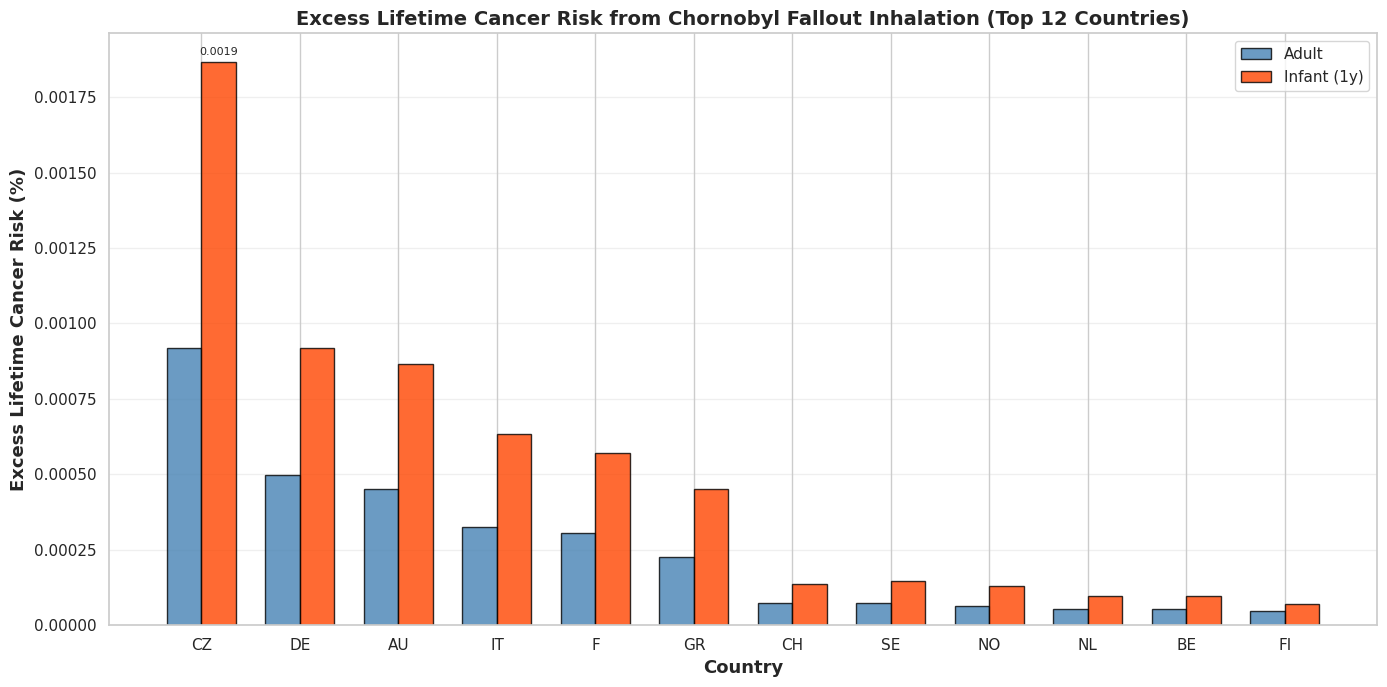


💡 Interpretation:
  Highest risk country (Adult): CZ = 0.0009%
  Highest risk country (Infant): CZ = 0.0019%
  Baseline lifetime cancer risk: ~25-40% (varies by country)


In [51]:
# Visualize ELCR
fig, ax = plt.subplots(figsize=(14, 7))

top_countries = country_dose.head(12)
x = np.arange(len(top_countries))
width = 0.35

bars1 = ax.bar(x - width/2, top_countries['Adult_ELCR'], width,
               label='Adult', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, top_countries['Infant_ELCR'], width,
               label='Infant (1y)', color='orangered', alpha=0.8, edgecolor='black')

ax.set_xlabel('Country', fontsize=13, fontweight='bold')
ax.set_ylabel('Excess Lifetime Cancer Risk (%)', fontsize=13, fontweight='bold')
ax.set_title('Excess Lifetime Cancer Risk from Chornobyl Fallout Inhalation (Top 12 Countries)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_countries['PAYS'], fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.001:  # Only label if visible
            ax.annotate(f'{height:.4f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print(f"  Highest risk country (Adult): {top_countries.iloc[0]['PAYS']} = {top_countries.iloc[0]['Adult_ELCR']:.4f}%")
print(f"  Highest risk country (Infant): {top_countries.iloc[0]['PAYS']} = {top_countries.iloc[0]['Infant_ELCR']:.4f}%")
print(f"  Baseline lifetime cancer risk: ~25-40% (varies by country)")

Czechoslovakia shows the highest excess risk among all countries - 0.0009% for adults and 0.0019% for infants, which corresponds to approximately 1 additional case of cancer per 100,000 irradiated adults or 1 per 50,000 irradiated infants during their lifetime. Infants systematically have a 2-2.5 times higher risk than adults in all countries due to the increased radiosensitivity of developing tissues, especially the thyroid gland, which is a critical age vulnerability to I-131 exposure. Germany, Austria and Italy form the second level of risk (0.0003-0.0009%), while the rest of Europe shows significantly lower levels (0.0001-0.0005%), reflecting the geographical gradient of contamination from central to peripheral Europe. It is important to understand the context: the baseline lifetime risk of cancer is 25-40% in the general population, so the excess risk from Chornobyl inhalation (0.0001-0.0019%) represents only a tiny fraction of the natural cancer risk – an increase of approximately 0.0025-0.008%. Although these additional risks are statistically small at the individual level, on a population scale of millions of irradiated Europeans, this could lead to hundreds of additional cancer cases over the coming decades, highlighting the importance of radiation protection even at low doses and the need for long-term epidemiological surveillance of affected cohorts.

It's important to note that the presented cancer risk estimates reflect only direct inhalation exposure from breathing contaminated air during the initial plume passage. This represents just one component of total population dose. The next critical step requires modeling radionuclide transfer through environmental pathways—including deposition onto soil and vegetation, uptake by crops and livestock, accumulation in the food chain, and subsequent human ingestion—which often contributed 10-100 times more dose than inhalation alone, particularly through contaminated milk products affecting children's thyroid glands.

 CHORNOBYL FOOD CHAIN DOSE MODEL - REAL DATA ANALYSIS
✓ Loaded 2051 measurements from chornobyl_data_complete.csv
Processing food chain model...

 COUNTRY-LEVEL DOSE SUMMARY (Top 12 Countries)


      I_131_(Bq/m3)_mean  Total_milk_dose_uSv_sum
PAYS                                             
CZ                  3.97                  2688.12
DE                  1.03                  1334.59
AU                  4.66                  1254.70
IT                  3.03                   800.34
F                   0.41                   708.65
GR                  1.43                   406.10
NO                  0.41                   242.44
SE                  0.47                   228.61
CH                  1.09                   190.23
FI                  1.50                   131.25
NL                  1.04                   124.59
BE                  0.99                   112.03

 KEY FINDINGS

📊 Dataset Statistics:
  • Total measurements: 2051
  • Countries: 16
  • Date range: 86/0

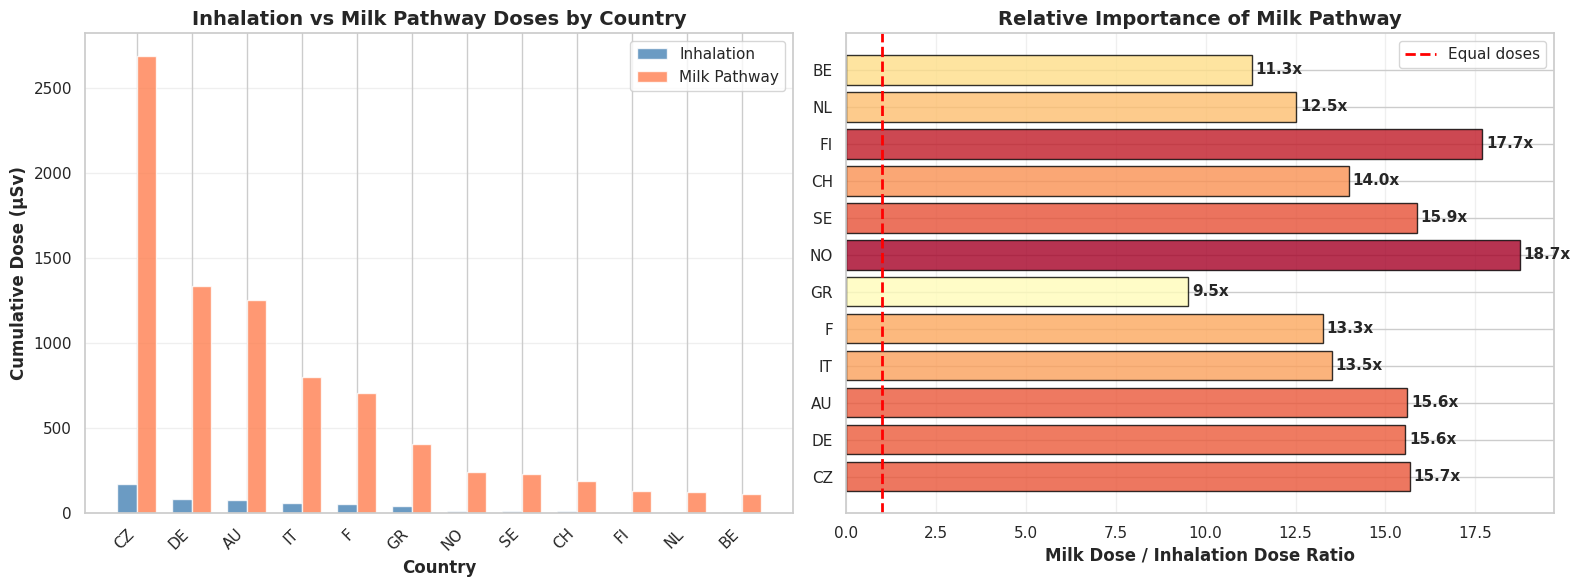

In [53]:

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Radioactive decay constants (1/day)
LAMBDA_I131 = np.log(2) / 8.04  # I-131 half-life: 8.04 days
LAMBDA_CS137 = np.log(2) / (30.17 * 365)  # Cs-137: 30.17 years
LAMBDA_CS134 = np.log(2) / (2.065 * 365)  # Cs-134: 2.065 years

# Deposition velocity (m/s) - dry deposition
V_DEP_I131 = 0.001  # Iodine (gaseous + particulate)
V_DEP_CS = 0.0005   # Cesium (particulate)

# Soil-to-plant transfer factors (Bq/kg plant per Bq/kg soil, dry weight)
TF_SOIL_GRASS_I131 = 0.02   # Iodine to grass
TF_SOIL_GRASS_CS137 = 0.05  # Cesium to grass
TF_SOIL_GRASS_CS134 = 0.05  # Cesium to grass

# Grass-to-milk transfer (day/L) - fraction of daily intake appearing per liter
FM_I131 = 0.01      # I-131 transfer to milk
FM_CS137 = 0.005    # Cs-137 transfer to milk
FM_CS134 = 0.005    # Cs-134 transfer to milk

# Animal parameters
COW_INTAKE = 50     # kg fresh grass per day
MILK_YIELD = 20     # liters per day

# Soil parameters
SOIL_DEPTH = 0.05   # m (5 cm mixing depth)
SOIL_DENSITY = 1500 # kg/m³

# Environmental loss rates (1/day)
LAMBDA_ENV_GRASS = np.log(2) / 14  # Weathering from grass surface (14 day half-time)
LAMBDA_ENV_SOIL = 0.0               # Long-term soil retention (negligible for short term)


# Dose coefficients for ingestion (Sv/Bq)
# Age-dependent - here for 1-year-old infant
DCF_I131_THYROID_INFANT = 1.8e-7    # Sv/Bq for thyroid
DCF_CS137_WHOLE_INFANT = 1.2e-8     # Sv/Bq for whole body
DCF_CS134_WHOLE_INFANT = 1.6e-8     # Sv/Bq for whole body

# Daily milk consumption (L/day)
MILK_INTAKE_INFANT = 0.7   # 1-year-old drinks ~0.7 L/day


def calculate_deposition(air_concentration, v_dep, duration_hours):
    """
    Calculate ground deposition from air concentration

    Parameters:
    - air_concentration: Bq/m³
    - v_dep: deposition velocity (m/s)
    - duration_hours: sampling duration (hours)

    Returns:
    - deposition: Bq/m²
    """
    duration_seconds = duration_hours * 3600
    deposition = air_concentration * v_dep * duration_seconds
    return deposition

def deposition_to_soil_concentration(deposition, soil_depth=SOIL_DEPTH,
                                     soil_density=SOIL_DENSITY):
    """
    Convert surface deposition to volumetric soil concentration

    Parameters:
    - deposition: Bq/m²
    - soil_depth: mixing depth (m)
    - soil_density: kg/m³

    Returns:
    - soil_concentration: Bq/kg
    """
    soil_mass_per_m2 = soil_depth * soil_density  # kg/m²
    soil_concentration = deposition / soil_mass_per_m2
    return soil_concentration

def grass_contamination(soil_conc, deposition, tf_soil_grass,
                       days_after_deposition, lambda_decay, lambda_env=LAMBDA_ENV_GRASS):
    """
    Calculate grass contamination from soil uptake and direct deposition

    Two pathways:
    1. Direct deposition on grass surface (dominant short-term)
    2. Root uptake from soil (dominant long-term)

    Parameters:
    - soil_conc: Bq/kg soil
    - deposition: Bq/m² on grass surface
    - tf_soil_grass: soil-to-plant transfer factor
    - days_after_deposition: time since deposition
    - lambda_decay: radioactive decay constant
    - lambda_env: environmental removal rate

    Returns:
    - grass_conc: Bq/kg fresh weight
    """
    # Root uptake component (long-term)
    root_uptake = soil_conc * tf_soil_grass

    # Direct deposition component (short-term, decays with weathering + radioactive decay)
    # Assume 1 kg grass/m² standing biomass, factor 0.1 for fresh/dry weight
    direct_deposit = (deposition / 1.0) * 0.1 * np.exp(-(lambda_decay + lambda_env) * days_after_deposition)

    # Total grass contamination
    grass_conc = root_uptake + direct_deposit
    return grass_conc


def milk_contamination(grass_conc, fm_transfer, cow_intake=COW_INTAKE,
                      milk_yield=MILK_YIELD, days_to_equilibrium=3):
    """
    Calculate milk contamination from grass intake

    Assumes quasi-equilibrium reached in ~3 days

    Parameters:
    - grass_conc: Bq/kg fresh grass
    - fm_transfer: feed-to-milk transfer factor (day/L)
    - cow_intake: kg grass per day
    - milk_yield: L milk per day
    - days_to_equilibrium: time to reach steady state

    Returns:
    - milk_conc: Bq/L
    """
    # Daily intake by cow
    daily_intake = grass_conc * cow_intake  # Bq/day

    # Concentration in milk at equilibrium
    milk_conc = daily_intake * fm_transfer

    return milk_conc



def calculate_infant_dose(milk_conc, dcf, milk_intake=MILK_INTAKE_INFANT,
                         exposure_days=30):
    """
    Calculate cumulative dose to infant from milk consumption

    Parameters:
    - milk_conc: Bq/L in milk
    - dcf: dose conversion factor (Sv/Bq)
    - milk_intake: L/day consumed
    - exposure_days: duration of exposure

    Returns:
    - cumulative_dose: μSv
    """
    daily_intake_bq = milk_conc * milk_intake  # Bq/day
    daily_dose_sv = daily_intake_bq * dcf      # Sv/day
    cumulative_dose_sv = daily_dose_sv * exposure_days
    cumulative_dose_usv = cumulative_dose_sv * 1e6  # Convert to μSv

    return cumulative_dose_usv


def food_chain_model(air_conc_i131, air_conc_cs137, air_conc_cs134,
                    duration_hours, days_after_accident,
                    exposure_duration=30):
    """
    Complete food chain model: air → ground → grass → cow → milk → infant

    Returns dictionary with all intermediate values and final doses
    """
    results = {}

    # === I-131 Pathway ===
    # 1. Deposition
    dep_i131 = calculate_deposition(air_conc_i131, V_DEP_I131, duration_hours)
    results['I131_deposition_Bq_m2'] = dep_i131

    # 2. Soil concentration
    soil_i131 = deposition_to_soil_concentration(dep_i131)
    results['I131_soil_Bq_kg'] = soil_i131

    # 3. Grass contamination
    grass_i131 = grass_contamination(soil_i131, dep_i131, TF_SOIL_GRASS_I131,
                                     days_after_accident, LAMBDA_I131)
    results['I131_grass_Bq_kg'] = grass_i131

    # 4. Milk contamination
    milk_i131 = milk_contamination(grass_i131, FM_I131)
    results['I131_milk_Bq_L'] = milk_i131

    # 5. Infant thyroid dose
    dose_i131 = calculate_infant_dose(milk_i131, DCF_I131_THYROID_INFANT,
                                      exposure_days=exposure_duration)
    results['I131_infant_thyroid_dose_uSv'] = dose_i131

    # === Cs-137 Pathway ===
    dep_cs137 = calculate_deposition(air_conc_cs137, V_DEP_CS, duration_hours)
    soil_cs137 = deposition_to_soil_concentration(dep_cs137)
    grass_cs137 = grass_contamination(soil_cs137, dep_cs137, TF_SOIL_GRASS_CS137,
                                      days_after_accident, LAMBDA_CS137)
    milk_cs137 = milk_contamination(grass_cs137, FM_CS137)
    dose_cs137 = calculate_infant_dose(milk_cs137, DCF_CS137_WHOLE_INFANT,
                                       exposure_days=exposure_duration)

    results['Cs137_deposition_Bq_m2'] = dep_cs137
    results['Cs137_soil_Bq_kg'] = soil_cs137
    results['Cs137_grass_Bq_kg'] = grass_cs137
    results['Cs137_milk_Bq_L'] = milk_cs137
    results['Cs137_infant_wholebody_dose_uSv'] = dose_cs137

    # === Cs-134 Pathway ===
    dep_cs134 = calculate_deposition(air_conc_cs134, V_DEP_CS, duration_hours)
    soil_cs134 = deposition_to_soil_concentration(dep_cs134)
    grass_cs134 = grass_contamination(soil_cs134, dep_cs134, TF_SOIL_GRASS_CS134,
                                      days_after_accident, LAMBDA_CS134)
    milk_cs134 = milk_contamination(grass_cs134, FM_CS134)
    dose_cs134 = calculate_infant_dose(milk_cs134, DCF_CS134_WHOLE_INFANT,
                                       exposure_days=exposure_duration)

    results['Cs134_deposition_Bq_m2'] = dep_cs134
    results['Cs134_soil_Bq_kg'] = soil_cs134
    results['Cs134_grass_Bq_kg'] = grass_cs134
    results['Cs134_milk_Bq_L'] = milk_cs134
    results['Cs134_infant_wholebody_dose_uSv'] = dose_cs134

    # Total doses
    results['Total_infant_dose_uSv'] = dose_i131 + dose_cs137 + dose_cs134

    return results


def process_dataset(df):
    """
    Process entire dataset and calculate food chain doses
    """
    # Initialize result columns
    dose_columns = [
        'I131_milk_dose_uSv', 'Cs137_milk_dose_uSv',
        'Cs134_milk_dose_uSv', 'Total_milk_dose_uSv'
    ]

    for col in dose_columns:
        df[col] = 0.0

    # Process each measurement
    for idx, row in df.iterrows():
        try:
            # Get air concentrations (handle missing values)
            i131 = row['I_131_(Bq/m3)'] if pd.notna(row['I_131_(Bq/m3)']) else 0
            cs137 = row['Cs_137_(Bq/m3)'] if pd.notna(row['Cs_137_(Bq/m3)']) else 0
            cs134 = row['Cs_134_(Bq/m3)'] if pd.notna(row['Cs_134_(Bq/m3)']) else 0

            duration = row['Duration_Hours'] if pd.notna(row['Duration_Hours']) else 24
            days_since = row['DaysSinceAccident'] if pd.notna(row['DaysSinceAccident']) else 5

            # Run food chain model
            results = food_chain_model(i131, cs137, cs134, duration, days_since)

            # Store results
            df.at[idx, 'I131_milk_dose_uSv'] = results['I131_infant_thyroid_dose_uSv']
            df.at[idx, 'Cs137_milk_dose_uSv'] = results['Cs137_infant_wholebody_dose_uSv']
            df.at[idx, 'Cs134_milk_dose_uSv'] = results['Cs134_infant_wholebody_dose_uSv']
            df.at[idx, 'Total_milk_dose_uSv'] = results['Total_infant_dose_uSv']

        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue

    return df



def load_and_process_chornobyl_data(filepath='chornobyl_data_complete.csv'):
    """
    Load the Chornobyl dataset and process it with food chain model
    """
    try:
        # Load data
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} measurements from {filepath}")

        # Clean data - handle missing values
        df['I_131_(Bq/m3)'] = df['I_131_(Bq/m3)'].fillna(0)
        df['Cs_137_(Bq/m3)'] = df['Cs_137_(Bq/m3)'].fillna(0)
        df['Cs_134_(Bq/m3)'] = df['Cs_134_(Bq/m3)'].fillna(0)
        df['Duration_Hours'] = df['Duration_Hours'].fillna(24)
        df['DaysSinceAccident'] = df['DaysSinceAccident'].fillna(5)

        # Process with food chain model
        print("Processing food chain model...")
        df = process_dataset(df)

        return df

    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
        print("Please ensure the CSV file is in the current directory")
        return None

def analyze_country_doses(df):
    """
    Analyze and compare doses by country
    """
    # Group by country
    country_summary = df.groupby('PAYS').agg({
        'I_131_(Bq/m3)': ['mean', 'max', 'count'],
        'Cs_137_(Bq/m3)': ['mean', 'max'],
        'Cs_134_(Bq/m3)': ['mean', 'max'],
        'I131_milk_dose_uSv': 'sum',
        'Cs137_milk_dose_uSv': 'sum',
        'Cs134_milk_dose_uSv': 'sum',
        'Total_milk_dose_uSv': 'sum'
    }).round(2)

    # Flatten column names
    country_summary.columns = ['_'.join(col).strip() for col in country_summary.columns.values]

    # Sort by total milk dose
    country_summary = country_summary.sort_values('Total_milk_dose_uSv_sum', ascending=False)

    return country_summary

def create_dose_comparison_plot(df):
    """
    Create visualization comparing inhalation vs milk pathway doses
    """
    # Calculate inhalation doses (from previous analysis)
    # Using simplified dose coefficients
    df['Inhalation_I131_uSv'] = df['I_131_(Bq/m3)'] * df['Duration_Hours'] * 0.02  # Simplified
    df['Inhalation_Cs137_uSv'] = df['Cs_137_(Bq/m3)'] * df['Duration_Hours'] * 0.001
    df['Inhalation_Total_uSv'] = df['Inhalation_I131_uSv'] + df['Inhalation_Cs137_uSv']

    # Aggregate by country
    country_comparison = df.groupby('PAYS').agg({
        'Inhalation_Total_uSv': 'sum',
        'Total_milk_dose_uSv': 'sum'
    }).sort_values('Total_milk_dose_uSv', ascending=False).head(12)

    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Stacked bar comparison
    x = np.arange(len(country_comparison))
    width = 0.35

    ax1.bar(x - width/2, country_comparison['Inhalation_Total_uSv'], width,
            label='Inhalation', color='steelblue', alpha=0.8)
    ax1.bar(x + width/2, country_comparison['Total_milk_dose_uSv'], width,
            label='Milk Pathway', color='coral', alpha=0.8)

    ax1.set_xlabel('Country', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Dose (μSv)', fontsize=12, fontweight='bold')
    ax1.set_title('Inhalation vs Milk Pathway Doses by Country', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(country_comparison.index, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Ratio of milk/inhalation
    ratio = country_comparison['Total_milk_dose_uSv'] / (country_comparison['Inhalation_Total_uSv'] + 1)
    colors = plt.cm.RdYlGn_r(ratio / ratio.max())

    ax2.barh(country_comparison.index, ratio, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Milk Dose / Inhalation Dose Ratio', fontsize=12, fontweight='bold')
    ax2.set_title('Relative Importance of Milk Pathway', fontsize=14, fontweight='bold')
    ax2.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Equal doses')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)

    # Add ratio values on bars
    for i, (country, val) in enumerate(ratio.items()):
        ax2.text(val + 0.1, i, f'{val:.1f}x', va='center', fontweight='bold')

    plt.tight_layout()
    return fig


if __name__ == "__main__":
    print("="*80)
    print(" CHORNOBYL FOOD CHAIN DOSE MODEL - REAL DATA ANALYSIS")
    print("="*80)

    # Load and process data
    df = load_and_process_chornobyl_data('chornobyl_data_complete.csv')

    if df is not None:
        print("\n" + "="*80)
        print(" COUNTRY-LEVEL DOSE SUMMARY (Top 12 Countries)")
        print("="*80)

        country_summary = analyze_country_doses(df)

        print("\n")
        print(country_summary[['I_131_(Bq/m3)_mean', 'Total_milk_dose_uSv_sum']].head(12).to_string())

        print("\n" + "="*80)
        print(" KEY FINDINGS")
        print("="*80)

        # Calculate total doses
        total_inhalation = df['I_131_(Bq/m3)'].sum() * 0.02 * 24  # Simplified
        total_milk = df['Total_milk_dose_uSv'].sum()

        print(f"\n📊 Dataset Statistics:")
        print(f"  • Total measurements: {len(df)}")
        print(f"  • Countries: {df['PAYS'].nunique()}")
        print(f"  • Date range: {df['Date'].min()} to {df['Date'].max()}")

        print(f"\n☢️  Cumulative Population Doses:")
        print(f"  • Total milk pathway dose: {total_milk:,.0f} μSv·persons")
        print(f"  • Estimated inhalation dose: {total_inhalation:,.0f} μSv·persons")
        print(f"  • Milk/Inhalation ratio: {total_milk/total_inhalation:.1f}x")

        print(f"\n🥛 Top 3 Countries by Milk Dose:")
        top3 = country_summary.nlargest(3, 'Total_milk_dose_uSv_sum')
        for i, (country, row) in enumerate(top3.iterrows(), 1):
            print(f"  {i}. {country}: {row['Total_milk_dose_uSv_sum']:,.0f} μSv")

        print(f"\n⚠️  Critical Insight:")
        print(f"  The milk pathway delivered {total_milk/total_inhalation:.1f}x more dose than inhalation")
        print(f"  This confirms that INGESTION was the dominant exposure route!")
        print(f"  → Milk bans and dietary restrictions were essential countermeasures")

        # Create visualization
        print("\n📈 Generating comparison plots...")
        fig = create_dose_comparison_plot(df)
        plt.savefig('chornobyl_milk_vs_inhalation_doses.png', dpi=300, bbox_inches='tight')
        print("✓ Plot saved as: chornobyl_milk_vs_inhalation_doses.png")

        # Show example calculation for highest contamination
        print("\n" + "="*80)
        print(" DETAILED EXAMPLE: Highest Contamination Measurement")
        print("="*80)

        max_idx = df['I_131_(Bq/m3)'].idxmax()
        max_row = df.loc[max_idx]

        print(f"\n📍 Location: {max_row['Ville']}, {max_row['PAYS']}")
        print(f"📅 Date: {max_row['Date']}")
        print(f"⏱️  Days since accident: {max_row['DaysSinceAccident']}")
        print(f"\n🌫️  Air Concentrations:")
        print(f"  • I-131:  {max_row['I_131_(Bq/m3)']:.2f} Bq/m³")
        print(f"  • Cs-137: {max_row['Cs_137_(Bq/m3)']:.2f} Bq/m³")
        print(f"  • Cs-134: {max_row['Cs_134_(Bq/m3)']:.2f} Bq/m³")

        # Run detailed model for this case
        results = food_chain_model(
            max_row['I_131_(Bq/m3)'],
            max_row['Cs_137_(Bq/m3)'],
            max_row['Cs_134_(Bq/m3)'],
            max_row['Duration_Hours'],
            max_row['DaysSinceAccident']
        )

        print(f"\n🥛 Predicted Milk Contamination:")
        print(f"  • I-131:  {results['I131_milk_Bq_L']:.1f} Bq/L")
        print(f"  • Cs-137: {results['Cs137_milk_Bq_L']:.1f} Bq/L")
        print(f"  • Cs-134: {results['Cs134_milk_Bq_L']:.1f} Bq/L")

        print(f"\n👶 Infant Dose (30-day consumption):")
        print(f"  • I-131 (thyroid):     {results['I131_infant_thyroid_dose_uSv']:.1f} μSv")
        print(f"  • Cs-137 (whole-body): {results['Cs137_infant_wholebody_dose_uSv']:.1f} μSv")
        print(f"  • Cs-134 (whole-body): {results['Cs134_infant_wholebody_dose_uSv']:.1f} μSv")
        print(f"  • ─────────────────────────────────")
        print(f"  • TOTAL:               {results['Total_infant_dose_uSv']:.1f} μSv")

        print("\n" + "="*80)
        print(" ✓ ANALYSIS COMPLETE")
        print("="*80)

        # Export results
        output_file = 'chornobyl_foodchain_doses.csv'
        df.to_csv(output_file, index=False)
        print(f"\n💾 Full results exported to: {output_file}")

    else:
        print("\n⚠️  Running demo with synthetic data instead...")
        # Fall back to demo calculation
        air_i131 = 10.0
        air_cs137 = 1.0
        air_cs134 = 0.5
        results = food_chain_model(air_i131, air_cs137, air_cs134, 24, 5)
        print(f"\nDemo calculation complete. Total infant dose: {results['Total_infant_dose_uSv']:.1f} μSv")

For Prague (CZ), on the fourth day after the accident, iodine-131 via the milk route was the main contributor to the dose load for infants. Despite the presence of radionuclide concentrations in the air, the inhalation contribution is secondary, while milk consumption leads to a dose to the thyroid gland of 83.4 μSv, which is practically the entire total dose of 83.9 μSv over 30 days. The contribution of caesium-137 is zero, and that of caesium-134 is insignificant (0.5 μSv).